## Note: This is a sample solution for the project. Projects will NOT be graded on the basis of how well the submission matches this sample solution. Projects will be graded on the basis of the rubric only.

## Context

The stock market has consistently proven to be a good place to invest in and save for the future. There are a lot of compelling reasons to invest in stocks. It can help in fighting inflation, create wealth, and also provides some tax benefits. Good steady returns on investments over a long period of time can also grow a lot more than seems possible. Also, thanks to the power of compound interest, the earlier one starts investing, the larger the corpus one can have for retirement. Overall, investing in stocks can help meet life's financial aspirations.

It is important to maintain a diversified portfolio when investing in stocks in order to maximise earnings under any market condition. Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. It is often easy to get lost in a sea of financial metrics to analyze while determining the worth of a stock, and doing the same for a multitude of stocks to identify the right picks for an individual can be a tedious task. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


## Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

In [125]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [126]:
# Convert a specific column to numeric
#df1['columnName'] = pd.to_numeric(df1['columnName'], errors='coerce')

In [127]:
# Select only numeric columns for correlation
#numeric_columns = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
#correlation_matrix = numeric_columns.corr()

# Print or use the correlation_matrix as needed
#print(correlation_matrix)

# !pip install yellowbrick

In [128]:
data = pd.read_csv("stock_data.csv")
data[:5]

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,AAL,American Airlines Group,Industrials,Airlines,42.349998,9.999995,1.687151,135,51,-604000000,7610000000,11.39,6.681299e+08,3.718174,-8.784219
1,ABBV,AbbVie,Health Care,Pharmaceuticals,59.240002,8.339433,2.197887,130,77,51000000,5144000000,3.15,1.633016e+09,18.806350,-8.750068
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,44.910000,11.301121,1.273646,21,67,938000000,4423000000,2.94,1.504422e+09,15.275510,-0.394171
3,ADBE,Adobe Systems Inc,Information Technology,Application Software,93.940002,13.977195,1.357679,9,180,-240840000,629551000,1.26,4.996437e+08,74.555557,4.199651
4,ADI,"Analog Devices, Inc.",Information Technology,Semiconductors,55.320000,-1.827858,1.701169,14,272,315120000,696878000,0.31,2.247994e+09,178.451613,1.059810


### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share 
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

In [129]:
data.shape

(340, 15)

In [130]:
# viewing 10 random rows of the data
data.sample(10, random_state=1)

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
102,DVN,Devon Energy Corp.,Energy,Oil & Gas Exploration & Production,32.000000,-15.478079,2.923698,205,70,830000000,-14454000000,-35.55,4.065823e+08,93.089287,1.785616
125,FB,Facebook,Information Technology,Internet Software & Services,104.660004,16.224320,1.320606,8,958,592000000,3669000000,1.31,2.800763e+09,79.893133,5.884467
11,AIV,Apartment Investment & Mgmt,Real Estate,REITs,40.029999,7.578608,1.163334,15,47,21818000,248710000,1.52,1.636250e+08,26.335526,-1.269332
248,PG,Procter & Gamble,Consumer Staples,Personal Products,79.410004,10.660538,0.806056,17,129,160383000,636056000,3.28,4.913916e+08,24.070121,-2.256747
238,OXY,Occidental Petroleum,Energy,Oil & Gas Exploration & Production,67.610001,0.865287,1.589520,32,64,-588000000,-7829000000,-10.23,7.652981e+08,93.089287,3.345102
336,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,52.516175,-8.698917,1.478877,142,27,159000000,1293000000,2.97,4.353535e+08,17.682214,-3.838260
112,EQT,EQT Corporation,Energy,Oil & Gas Exploration & Production,52.130001,-21.253771,2.364883,2,201,523803000,85171000,0.56,1.520911e+08,93.089287,9.567952
147,HAL,Halliburton Co.,Energy,Oil & Gas Equipment & Services,34.040001,-5.101751,1.966062,4,189,7786000000,-671000000,-0.79,8.493671e+08,93.089287,17.345857
89,DFS,Discover Financial Services,Financials,Consumer Finance,53.619999,3.653584,1.159897,20,99,2288000000,2297000000,5.14,4.468872e+08,10.431906,-0.375934
173,IVZ,Invesco Ltd.,Financials,Asset Management & Custody Banks,33.480000,7.067477,1.580839,12,67,412000000,968100000,2.26,4.283628e+08,14.814159,4.218620


In [131]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [132]:
# checking datatypes and number of non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

In [133]:
# checking for duplicate values
df.duplicated().sum()

0

In [134]:
# checking for missing values
df.isnull().sum()

Ticker Symbol                   0
Security                        0
GICS Sector                     0
GICS Sub Industry               0
Current Price                   0
Price Change                    0
Volatility                      0
ROE                             0
Cash Ratio                      0
Net Cash Flow                   0
Net Income                      0
Earnings Per Share              0
Estimated Shares Outstanding    0
P/E Ratio                       0
P/B Ratio                       0
dtype: int64

# Exploratory Data Analysis

In [135]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Ticker Symbol,340,340,AAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Security,340,340,American Airlines Group,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GICS Sector,340,11,Industrials,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GICS Sub Industry,340,104,Oil & Gas Exploration & Production,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Current Price,340.0,NaN,NaN,NaN,80.862345,98.055086,4.5,38.555,59.705,92.880001,1274.949951
Price Change,340.0,NaN,NaN,NaN,4.078194,12.006338,-47.129693,-0.939484,4.819505,10.695493,55.051683
Volatility,340.0,NaN,NaN,NaN,1.525976,0.591798,0.733163,1.134878,1.385593,1.695549,4.580042
ROE,340.0,NaN,NaN,NaN,39.597059,96.547538,1.0,9.75,15.0,27.0,917.0
Cash Ratio,340.0,NaN,NaN,NaN,70.023529,90.421331,0.0,18.0,47.0,99.0,958.0
Net Cash Flow,340.0,NaN,NaN,NaN,55537620.588235,1946365312.175789,-11208000000.0,-193906500.0,2098000.0,169810750.0,20764000000.0


**Observations**

- There are companies from 11 economic sectors and 104 sub-industry groups in the data.
    - Most of the companies are from the Industrials sector.
- The average current stock price of companies in the data is ~81 dollars.
- Companies in data have witnessed a 4.1% increase in stock price on average.
- Companies have had a net income of 1.5 billion dollars on average.

# Univariate analysis

In [136]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

**`Current Price`**

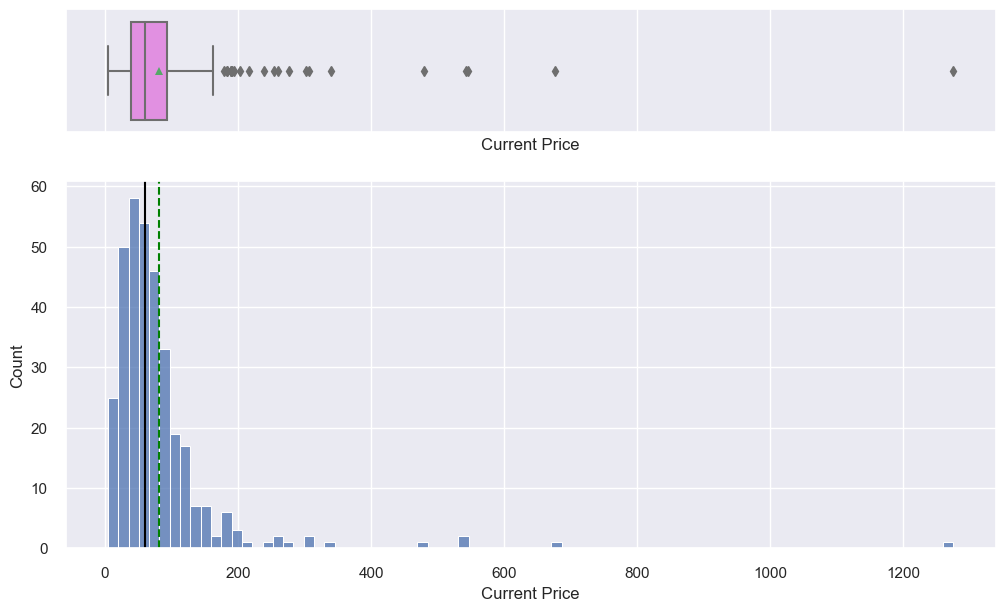

In [137]:
histogram_boxplot(df, 'Current Price')

- The distribution is heavily right-skewed and very few stocks have a price of more than 200 dollars.

#The statement "the distribution is heavily right-skewed and very few stocks have a price of more than 200 dollars" describes the distribution of stock prices in a dataset or market. Let's break down what this means:

Distribution: In statistics, a distribution refers to the way data is spread or distributed across different values. When talking about the distribution of stock prices, it means looking at how the prices of different stocks are spread across various price levels.

Right-Skewed Distribution: A right-skewed (positively skewed) distribution is one where the tail of the distribution extends towards the right, which means that there are relatively few extreme high values that pull the average (mean) of the data to the right. In the context of stock prices, a right-skewed distribution suggests that most stocks have lower prices, and only a few have very high prices.

Stock Prices: In this context, "stock prices" refer to the market prices of individual stocks. The price of a stock represents the cost of buying one share of that company's stock on the stock market.

Few Stocks with Price > 200 Dollars: This part of the statement indicates that the majority of stocks in the dataset or market have prices below #$200, and there are only a limited number of stocks whose prices exceed #$200 per share.

In practical terms, a right-skewed distribution of stock prices suggests that there are more stocks with lower prices (perhaps clustered around a certain range) and relatively fewer stocks with very high prices. This kind of distribution is often observed in financial markets, where most companies have stock prices within a certain range, but a few well-performing or high-value stocks can have significantly higher prices.

Investors and analysts often look at the distribution of stock prices to understand market dynamics, identify potential investment opportunities, and assess risk. The presence of outliers (stocks with extremely high prices) in a right-skewed distribution can be of particular interest, as they may represent companies with exceptional performance or unique characteristics.

**`Price Change`**

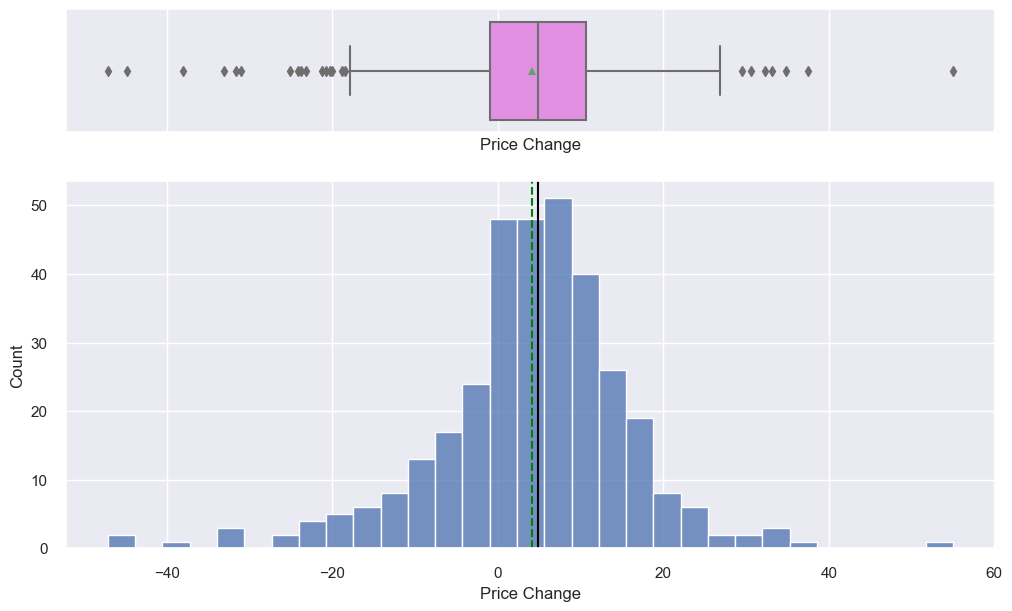

In [138]:
histogram_boxplot(df, 'Price Change')

- The distribution of percentage change in stock price is very close to normal.

**`Volatility`**

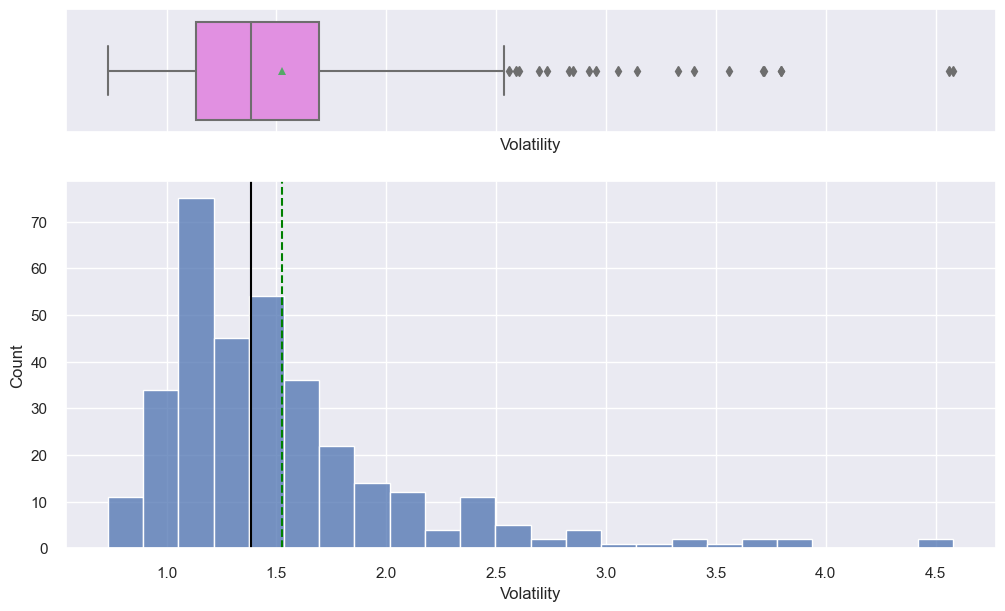

In [139]:
histogram_boxplot(df, 'Volatility')

- The distribution is slightly right-skewed and few stocks show very high volatility.

# **`ROE`**

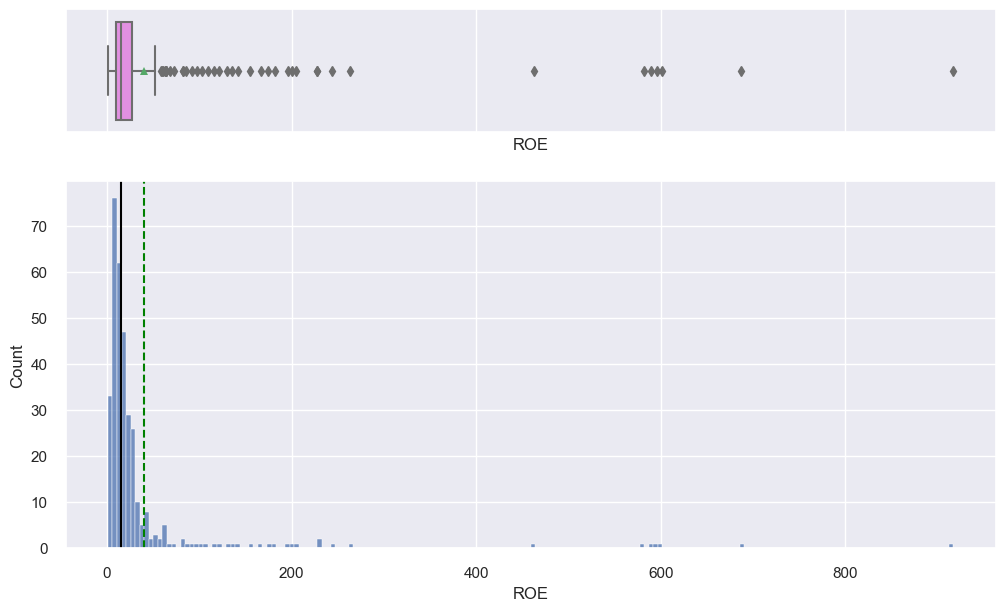

In [140]:
histogram_boxplot(df, 'ROE')

- The distribution is heavily right-skewed and very few stocks have an ROE of 100 or more.

# **`Cash Ratio`**

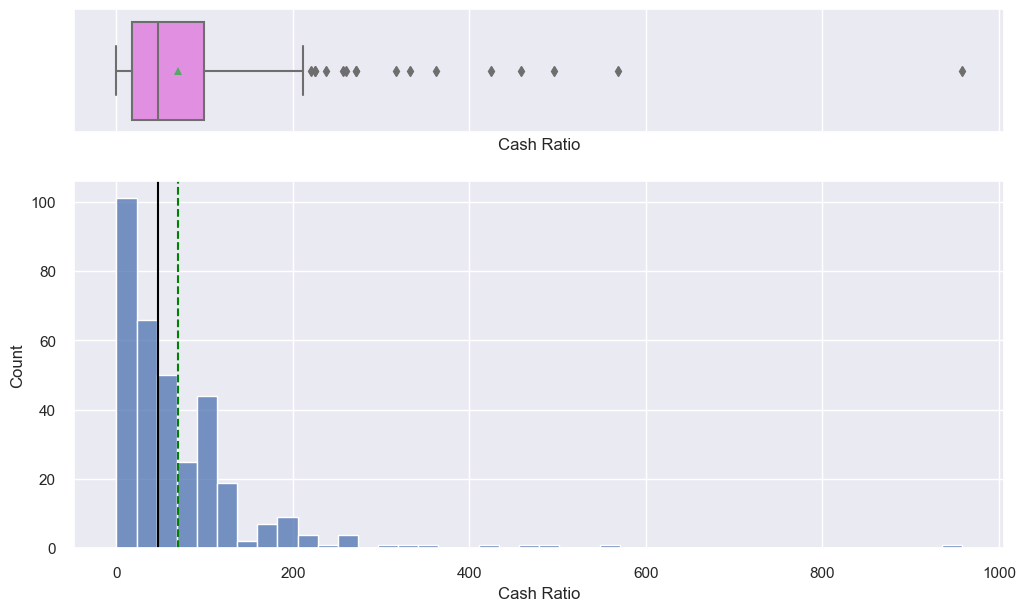

In [141]:
histogram_boxplot(df, 'Cash Ratio')

- The distribution is right-skewed and very few stocks have a cash ratio of more than 200.

**`Net Cash Flow`**

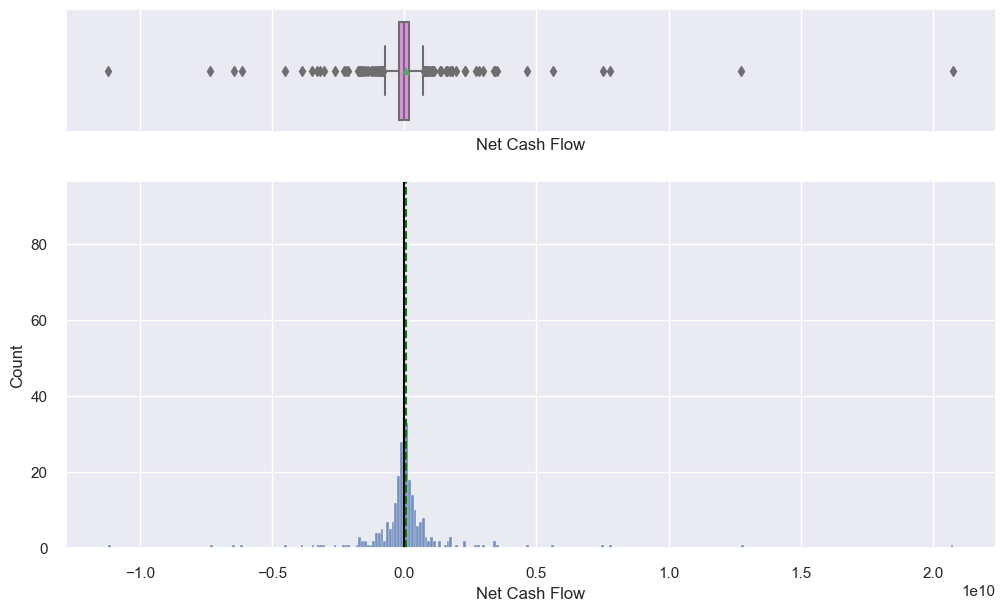

In [142]:
histogram_boxplot(df, 'Net Cash Flow')

- The distribution is close to normal with a lot of outliers.

In [143]:
#df['Cash Ratio'].value_counts()

**`Net Income`**

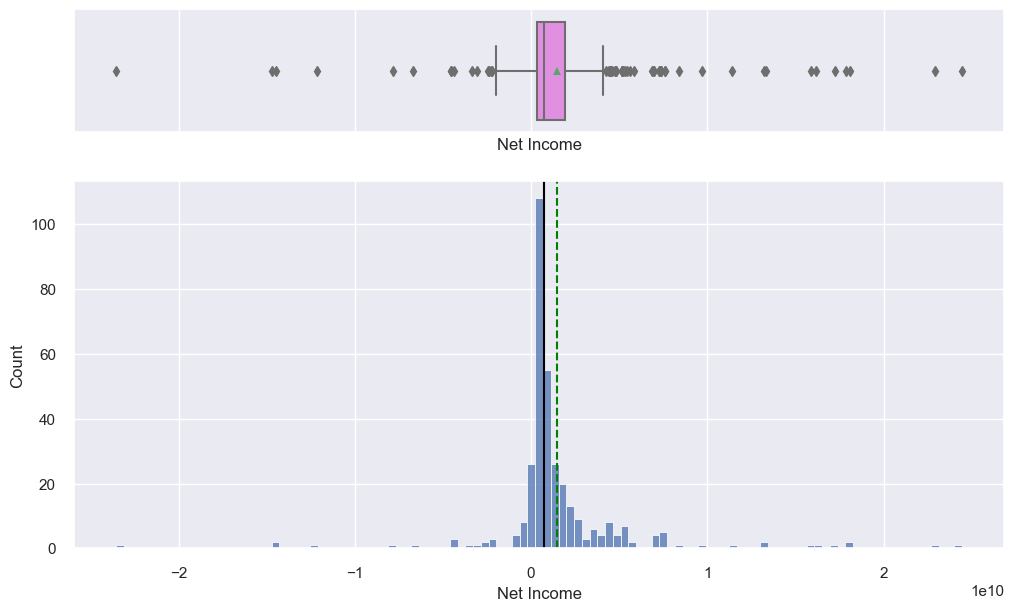

In [144]:
histogram_boxplot(df, 'Net Income')

- The distribution is close to normal with a lot of outliers.

**`Net Income`**

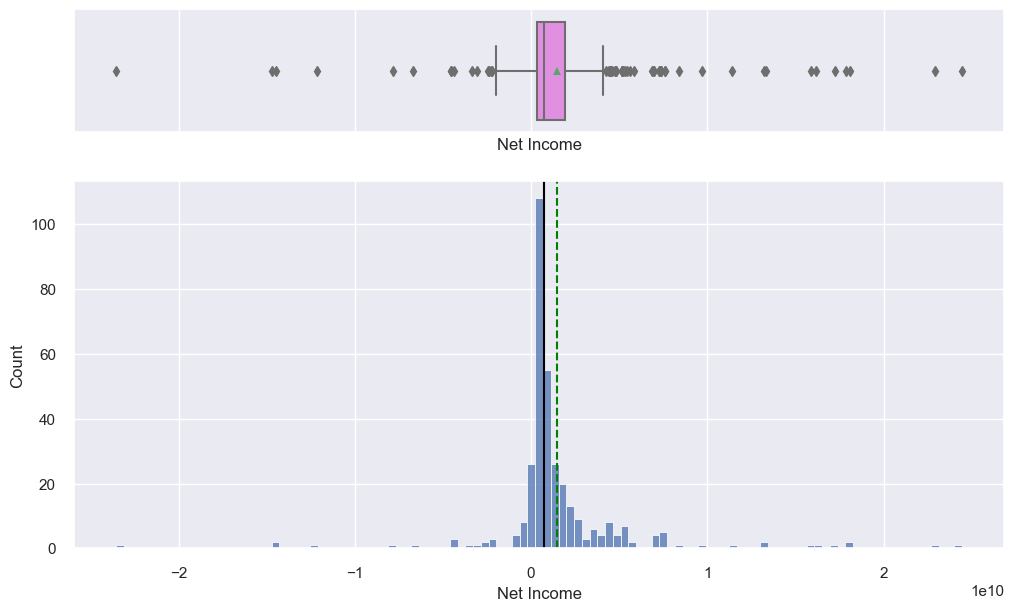

In [145]:
histogram_boxplot(df, 'Net Income')

- The distribution is close to normal with a lot of outliers.

**`Earnings Per Share`**

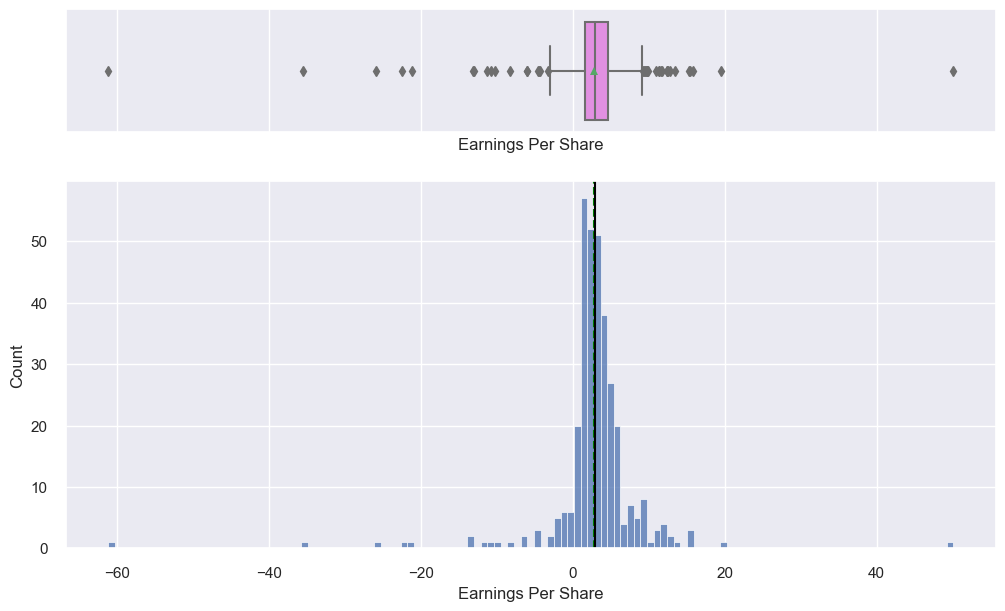

In [146]:
histogram_boxplot(df, 'Earnings Per Share')

- The distribution is close to normal with a lot of outliers.

**`Estimated Shares Outstanding`**

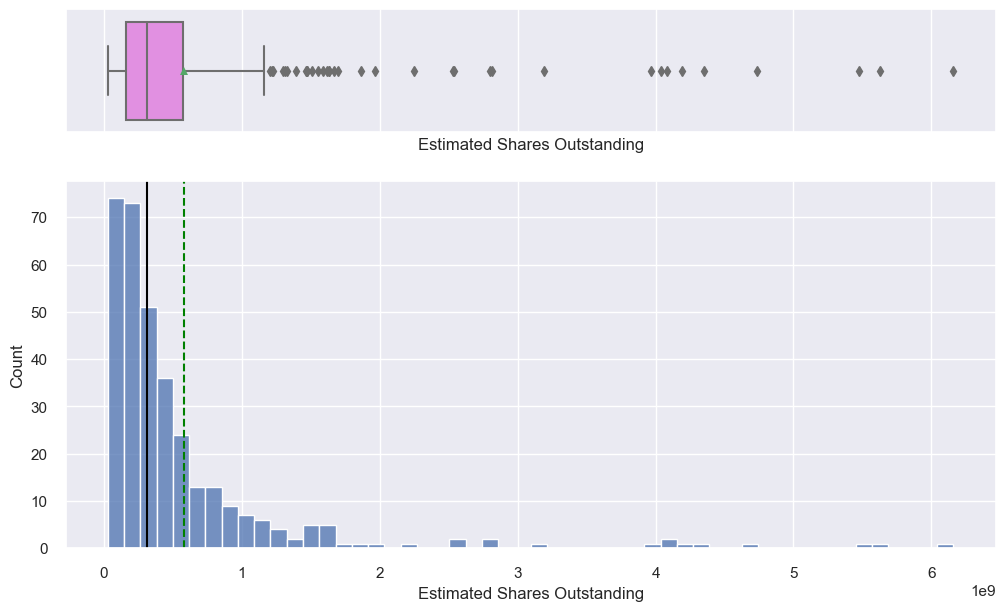

In [147]:
histogram_boxplot(df, 'Estimated Shares Outstanding')

- The distribution is right-skewed and few companies have more than a billion outstanding shares.

**`P/E Ratio`**

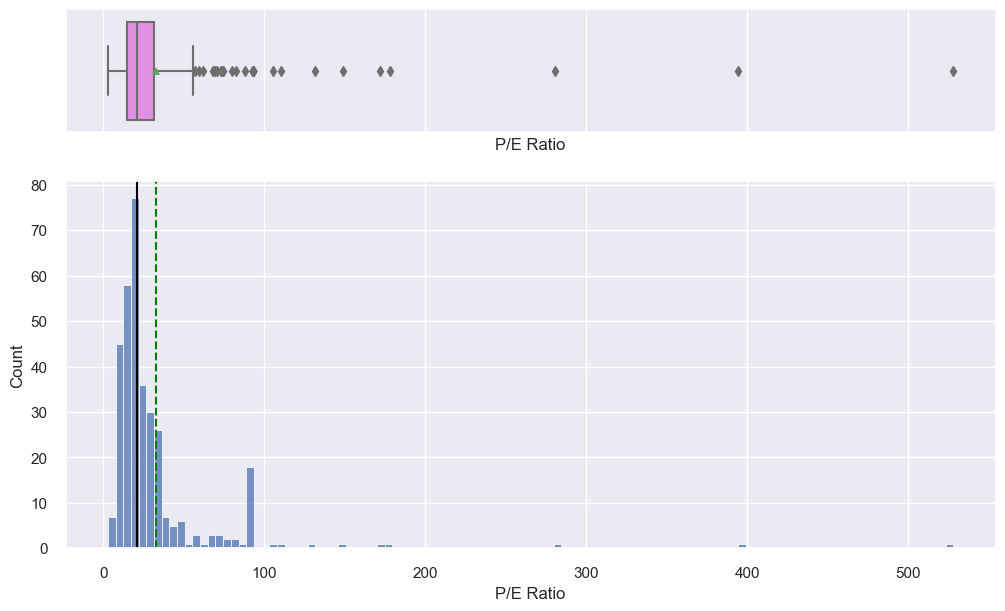

In [148]:
histogram_boxplot(df, 'P/E Ratio')

- The distribution is close to normal with a few outliers.

In [149]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot


**`GICS Sector`**

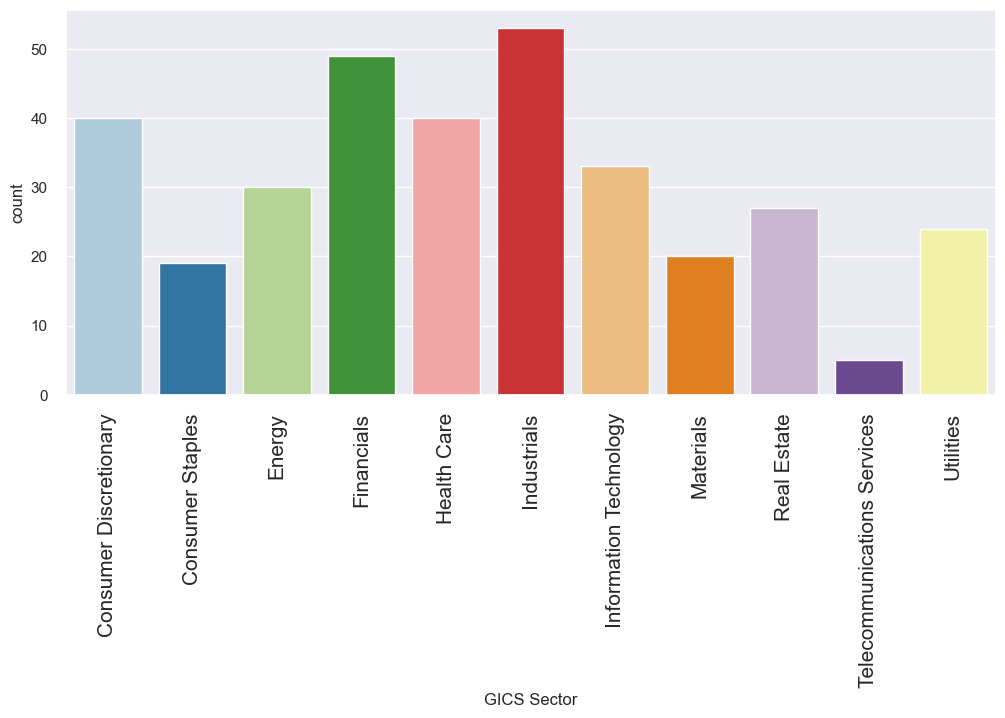

In [150]:
labeled_barplot(df, 'GICS Sector', perc=True)

- 30% of the companies in the data are from Financials and Industrials sectors.
- Telecommunication Services has the least weightage of companies in the data.

**`GICS Sub Industry`**

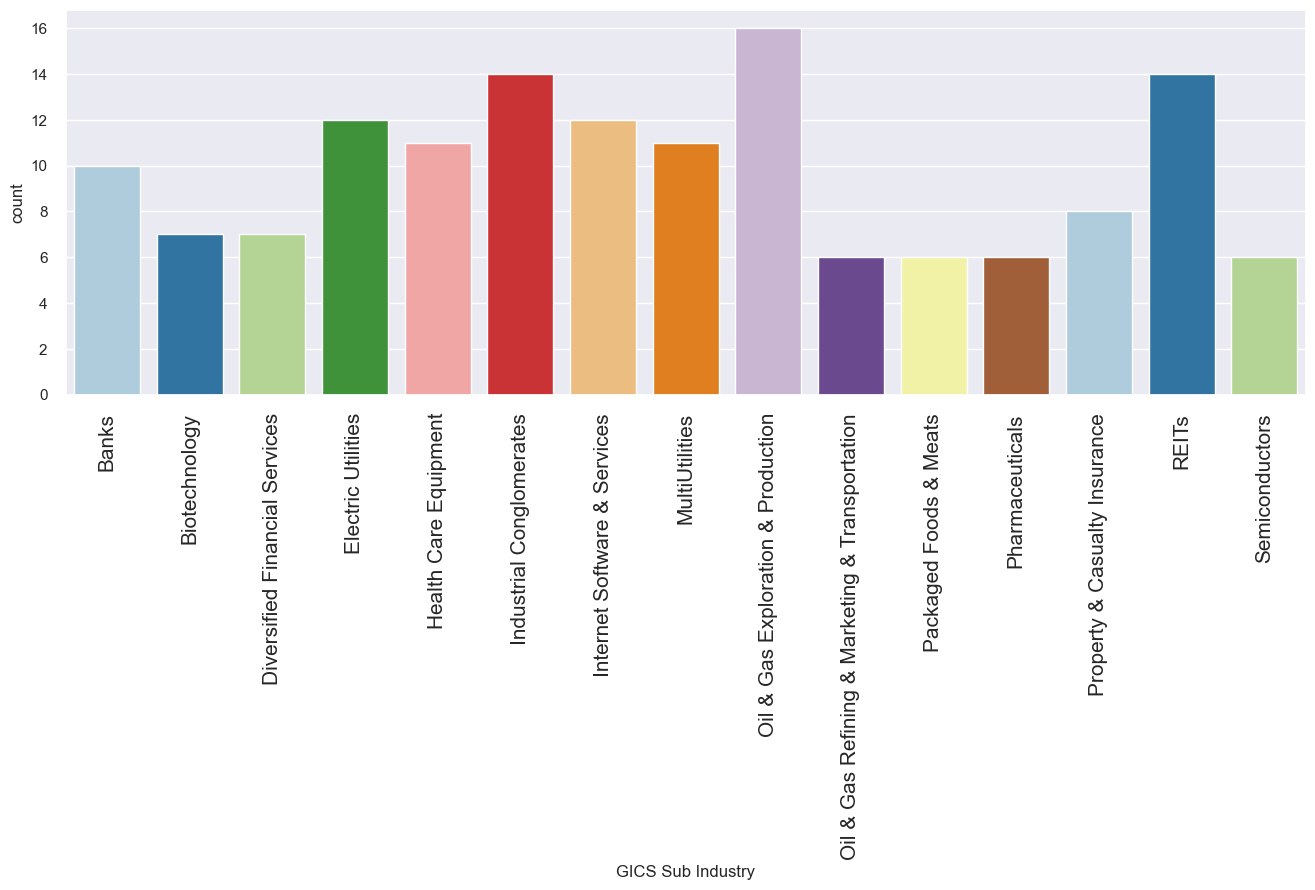

In [151]:
labeled_barplot(df, 'GICS Sub Industry', perc=True, n=15)

- Most of the companies in the data belong to the Oil and Gas Exploration and Production sub-industry.

# Bivariate Analysis

In [152]:
# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=['number'])
numeric_columns[:5]

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,42.349998,9.999995,1.687151,135,51,-604000000,7610000000,11.39,6.681299e+08,3.718174,-8.784219
1,59.240002,8.339433,2.197887,130,77,51000000,5144000000,3.15,1.633016e+09,18.806350,-8.750068
2,44.910000,11.301121,1.273646,21,67,938000000,4423000000,2.94,1.504422e+09,15.275510,-0.394171
3,93.940002,13.977195,1.357679,9,180,-240840000,629551000,1.26,4.996437e+08,74.555557,4.199651
4,55.320000,-1.827858,1.701169,14,272,315120000,696878000,0.31,2.247994e+09,178.451613,1.059810


In [153]:
# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()
correlation_matrix

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
Current Price,1.000000,0.134982,-0.124257,-0.000549,0.127816,-0.021961,0.036625,0.479604,-0.145306,0.260273,0.124634
Price Change,0.134982,1.000000,-0.408281,-0.043310,0.168586,0.026746,0.179298,0.175401,0.033656,-0.002491,0.034329
Volatility,-0.124257,-0.408281,1.000000,0.162532,0.020605,-0.014172,-0.383433,-0.379309,-0.095704,0.263600,0.046528
ROE,-0.000549,-0.043310,0.162532,1.000000,-0.069122,-0.052205,-0.288524,-0.405291,-0.030288,0.023341,-0.063218
Cash Ratio,0.127816,0.168586,0.020605,-0.069122,1.000000,0.113819,0.028589,0.024759,0.135869,0.089483,0.229672
Net Cash Flow,-0.021961,0.026746,-0.014172,-0.052205,0.113819,1.000000,0.044229,0.019348,-0.051392,0.026876,0.057039
Net Income,0.036625,0.179298,-0.383433,-0.288524,0.028589,0.044229,1.000000,0.557752,0.589310,-0.224022,-0.061544
Earnings Per Share,0.479604,0.175401,-0.379309,-0.405291,0.024759,0.019348,0.557752,1.000000,-0.026906,-0.260660,0.014915
Estimated Shares Outstanding,-0.145306,0.033656,-0.095704,-0.030288,0.135869,-0.051392,0.589310,-0.026906,1.000000,-0.014551,-0.028155
P/E Ratio,0.260273,-0.002491,0.263600,0.023341,0.089483,0.026876,-0.224022,-0.260660,-0.014551,1.000000,0.036422


In [154]:
# Print or use the correlation_matrix as needed
print(correlation_matrix)

                              Current Price  Price Change  Volatility  \
Current Price                      1.000000      0.134982   -0.124257   
Price Change                       0.134982      1.000000   -0.408281   
Volatility                        -0.124257     -0.408281    1.000000   
ROE                               -0.000549     -0.043310    0.162532   
Cash Ratio                         0.127816      0.168586    0.020605   
Net Cash Flow                     -0.021961      0.026746   -0.014172   
Net Income                         0.036625      0.179298   -0.383433   
Earnings Per Share                 0.479604      0.175401   -0.379309   
Estimated Shares Outstanding      -0.145306      0.033656   -0.095704   
P/E Ratio                          0.260273     -0.002491    0.263600   
P/B Ratio                          0.124634      0.034329    0.046528   

                                   ROE  Cash Ratio  Net Cash Flow  Net Income  \
Current Price                -0.000549    

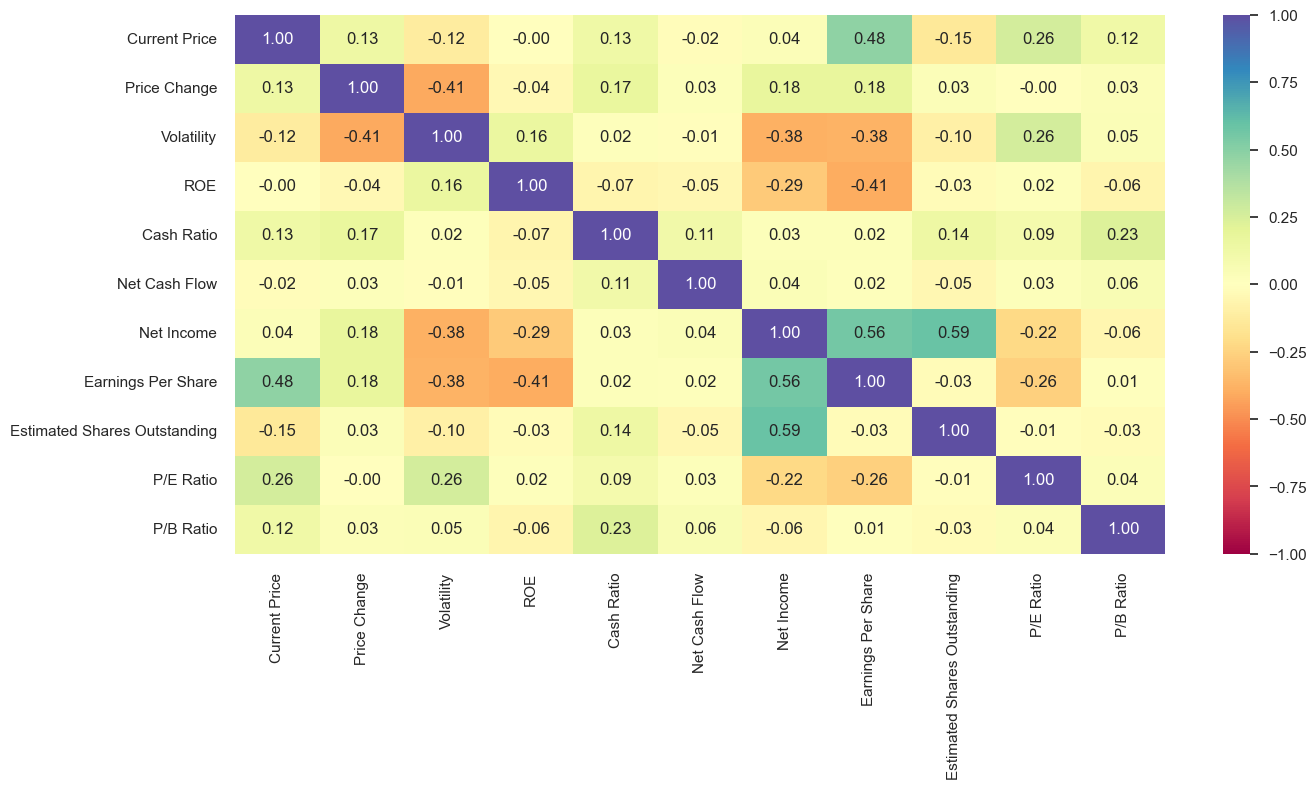

In [155]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    correlation_matrix, annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

**Observations**

- None of the variables show a very high correlation with each other.

- The net income of a company is positively correlated with the earnings per share and number of outstanding shares.
    -  This makes sense as the more money a company makes, the more each shareholder will earn and more people will be willing to invest in the company.
    
- Percentage change in price and price volatility are negatively correlated.

**Let's check the stocks of which economic sector have seen the maximum price increase on average.**

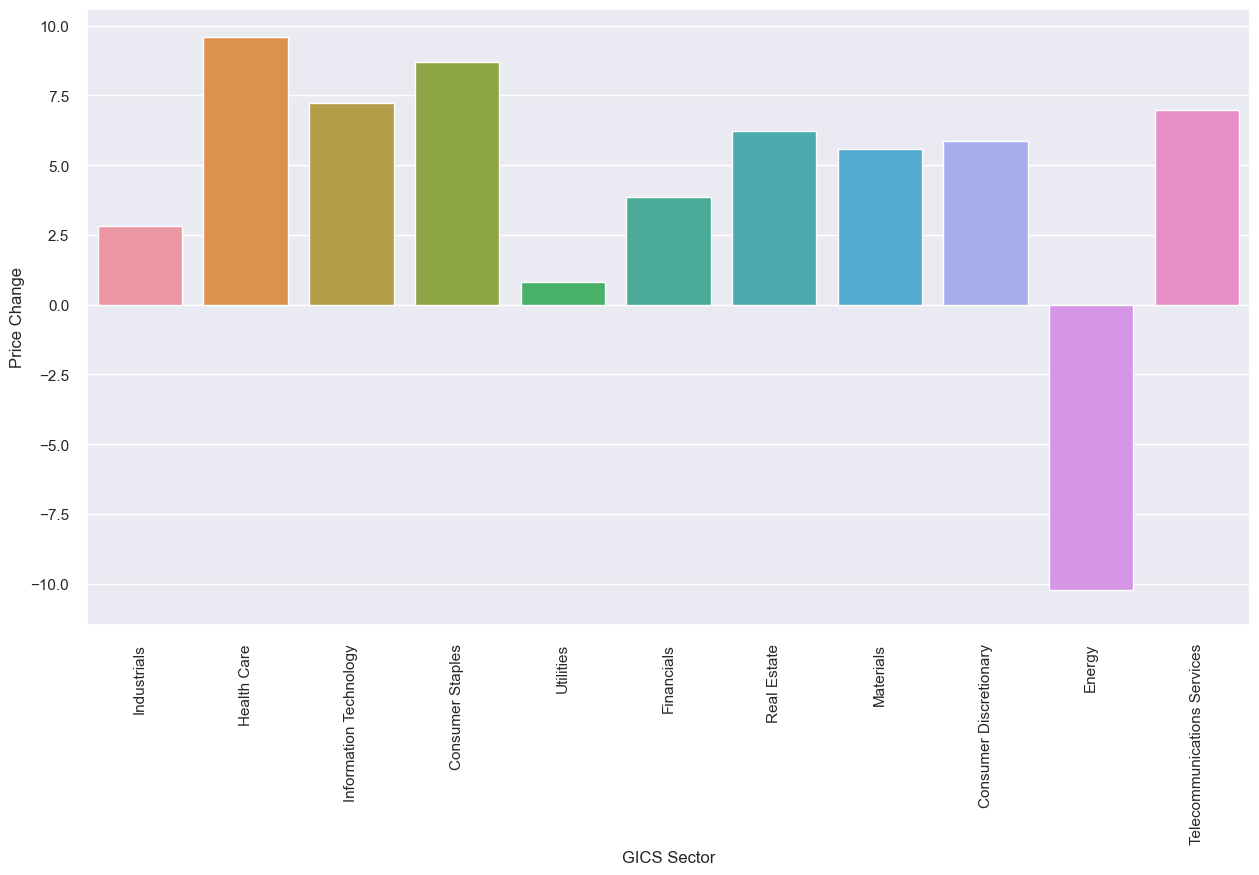

In [156]:
plt.figure(figsize=(15,8))
sns.barplot(data=df, x='GICS Sector', y='Price Change', ci=False)
plt.xticks(rotation=90)
plt.show()

- Stocks from the Healthcare sector witnessed the maximum price increase, with an ~9% increase, on average.
- Stocks from the Energy sector were the only ones to witness a price drop on average.

**Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. Let's see how the average cash ratio varies across economic sectors.**

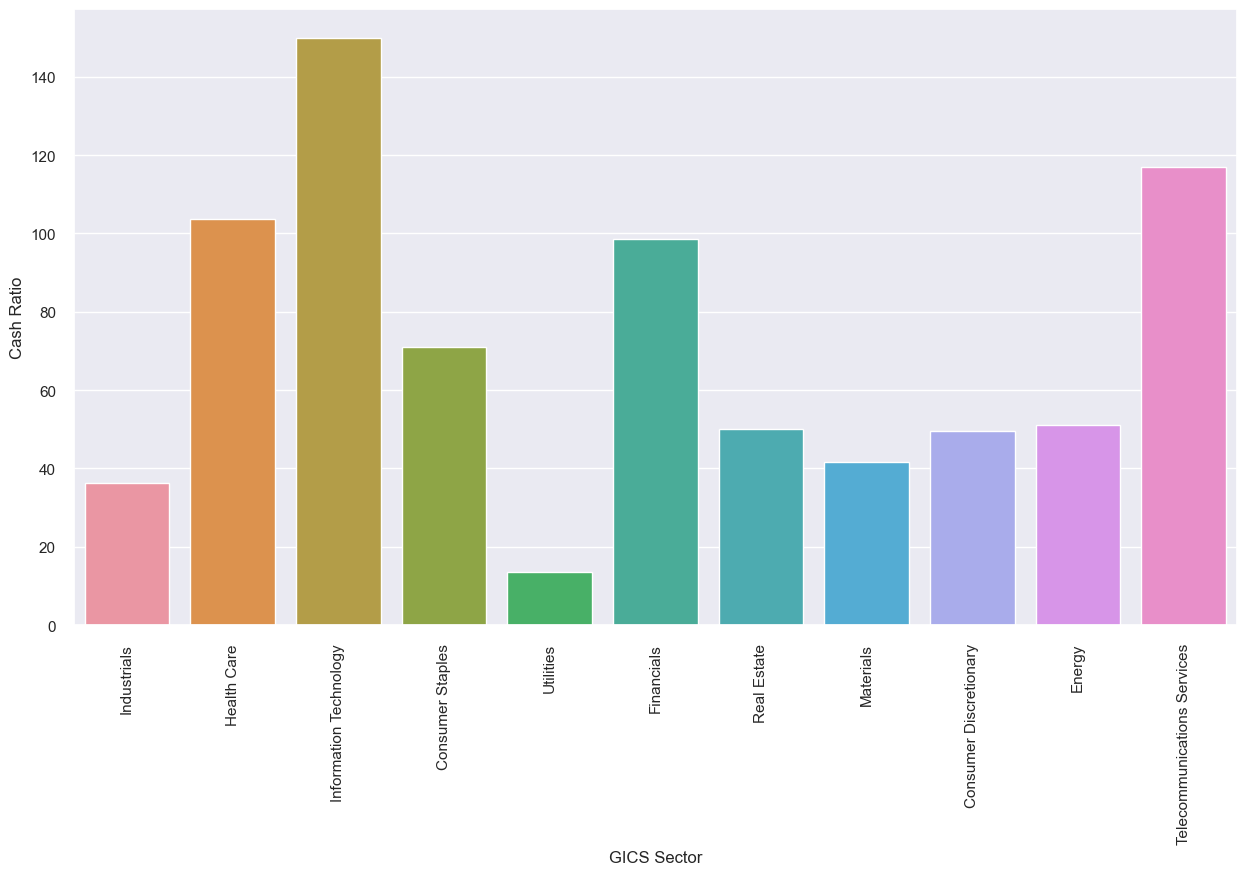

In [157]:
plt.figure(figsize=(15,8))
sns.barplot(data=df, x='GICS Sector', y='Cash Ratio', ci=False)
plt.xticks(rotation=90)
plt.show()

- IT sector companies have the highest cash ratio on average, so they are more likely to be able to cover their short-term obligations using only cash and cash equivalents.
- Utilities sector companies have the lowest cash ratio on average, so they are less likely to be able to cover their short-term obligations using only cash and cash equivalents.

**P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. Let's see how the P/E ratio varies, on average, across economic sectors.**

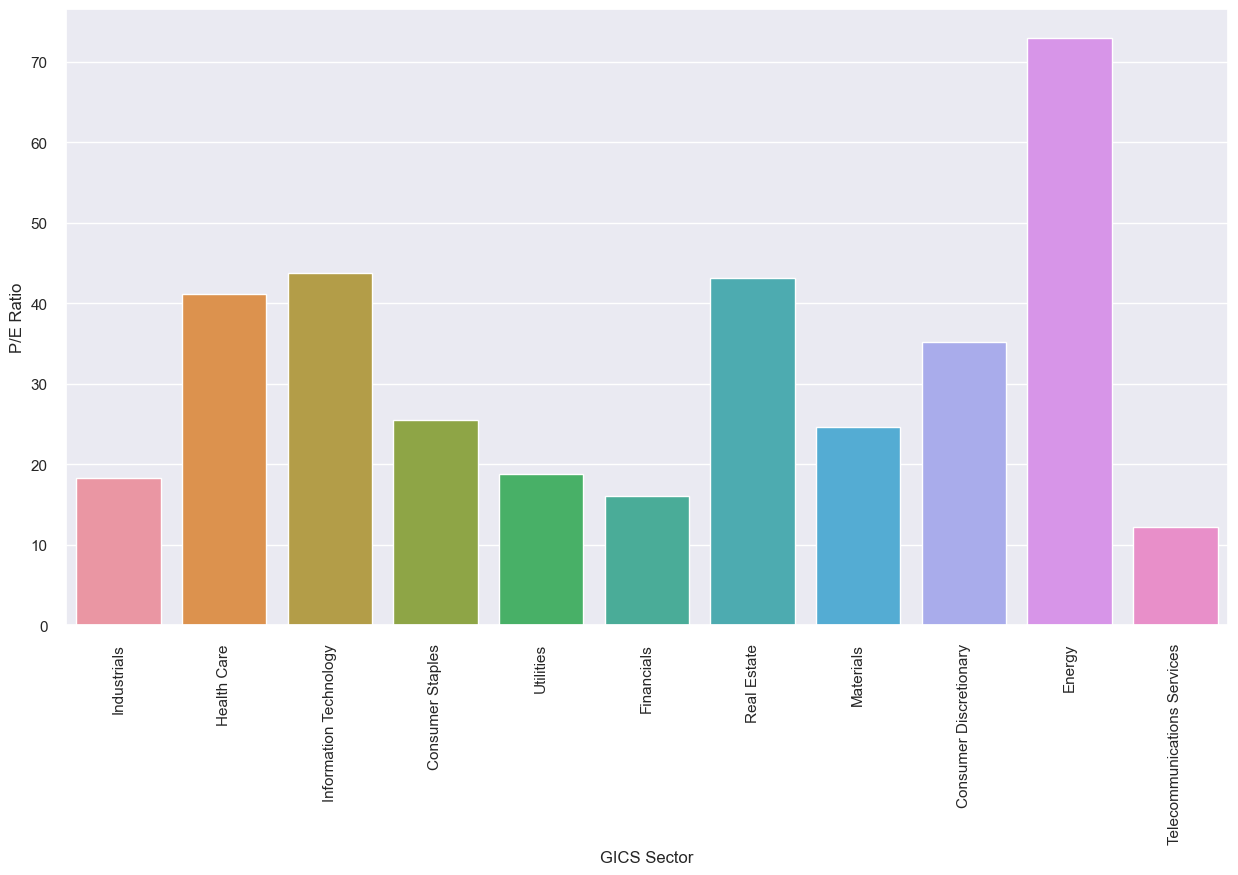

In [158]:
plt.figure(figsize=(15,8))
sns.barplot(data=df, x='GICS Sector', y='P/E Ratio', ci=False)
plt.xticks(rotation=90)
plt.show()

- The P/E ratio is highest (on average) for the Energy sector companies but they also witness an average price decrease over the past quarter. This might indicate that the stocks of this sector are overvalued.

**Volatility accounts for the fluctuation in the stock price. A stock with high volatility will witness sharper price changes, making it a riskier investment. Let's see how volatility varies, on average, across economic sectors.**

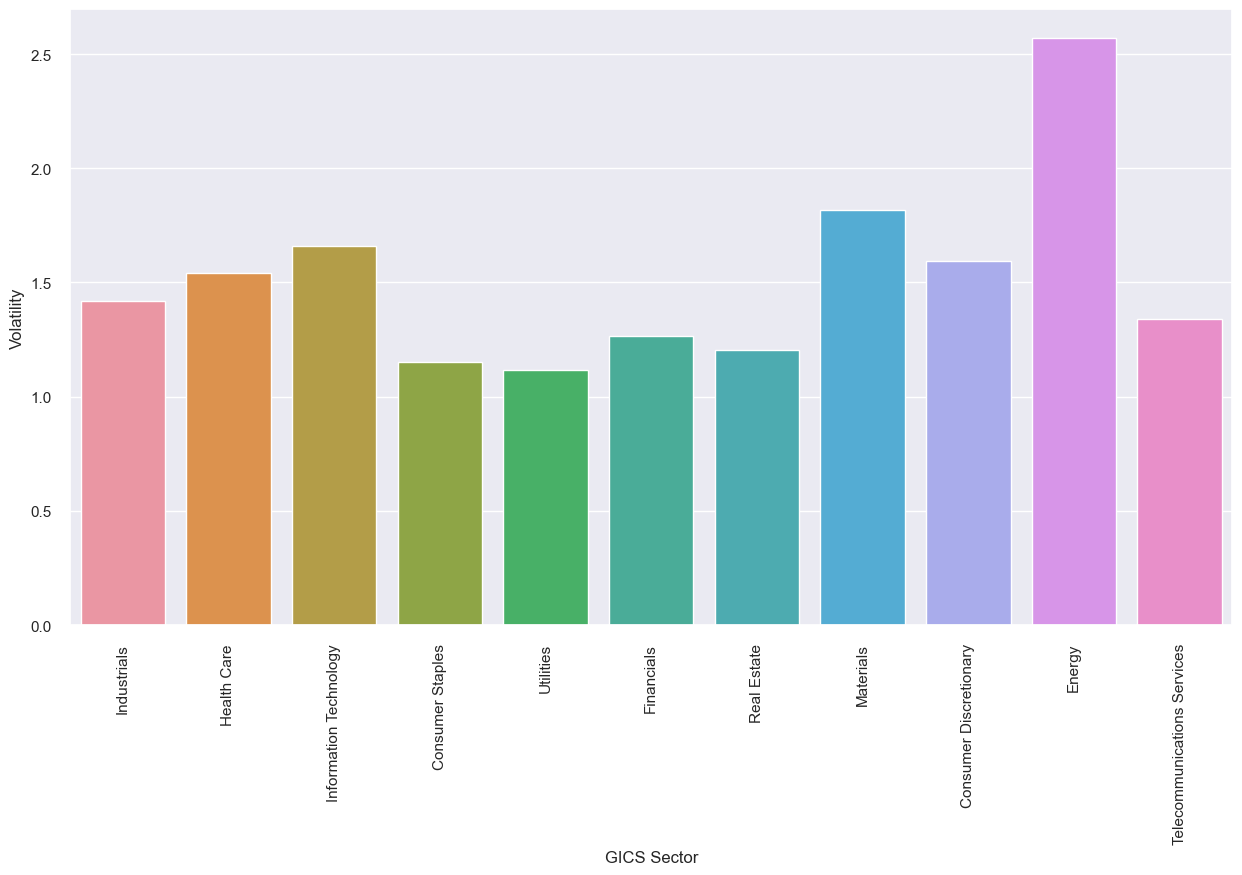

In [159]:
plt.figure(figsize=(15,8))
sns.barplot(data=df, x='GICS Sector', y='Volatility', ci=False)
plt.xticks(rotation=90)
plt.show()

- Stocks from the Energy sector exhibit high volatility on average, making them riskier investments.
- Consumer Staples and Utilities stocks are less riskier investments.

# Outlier Check

- Let's plot the boxplots of all numerical columns to check for outliers.

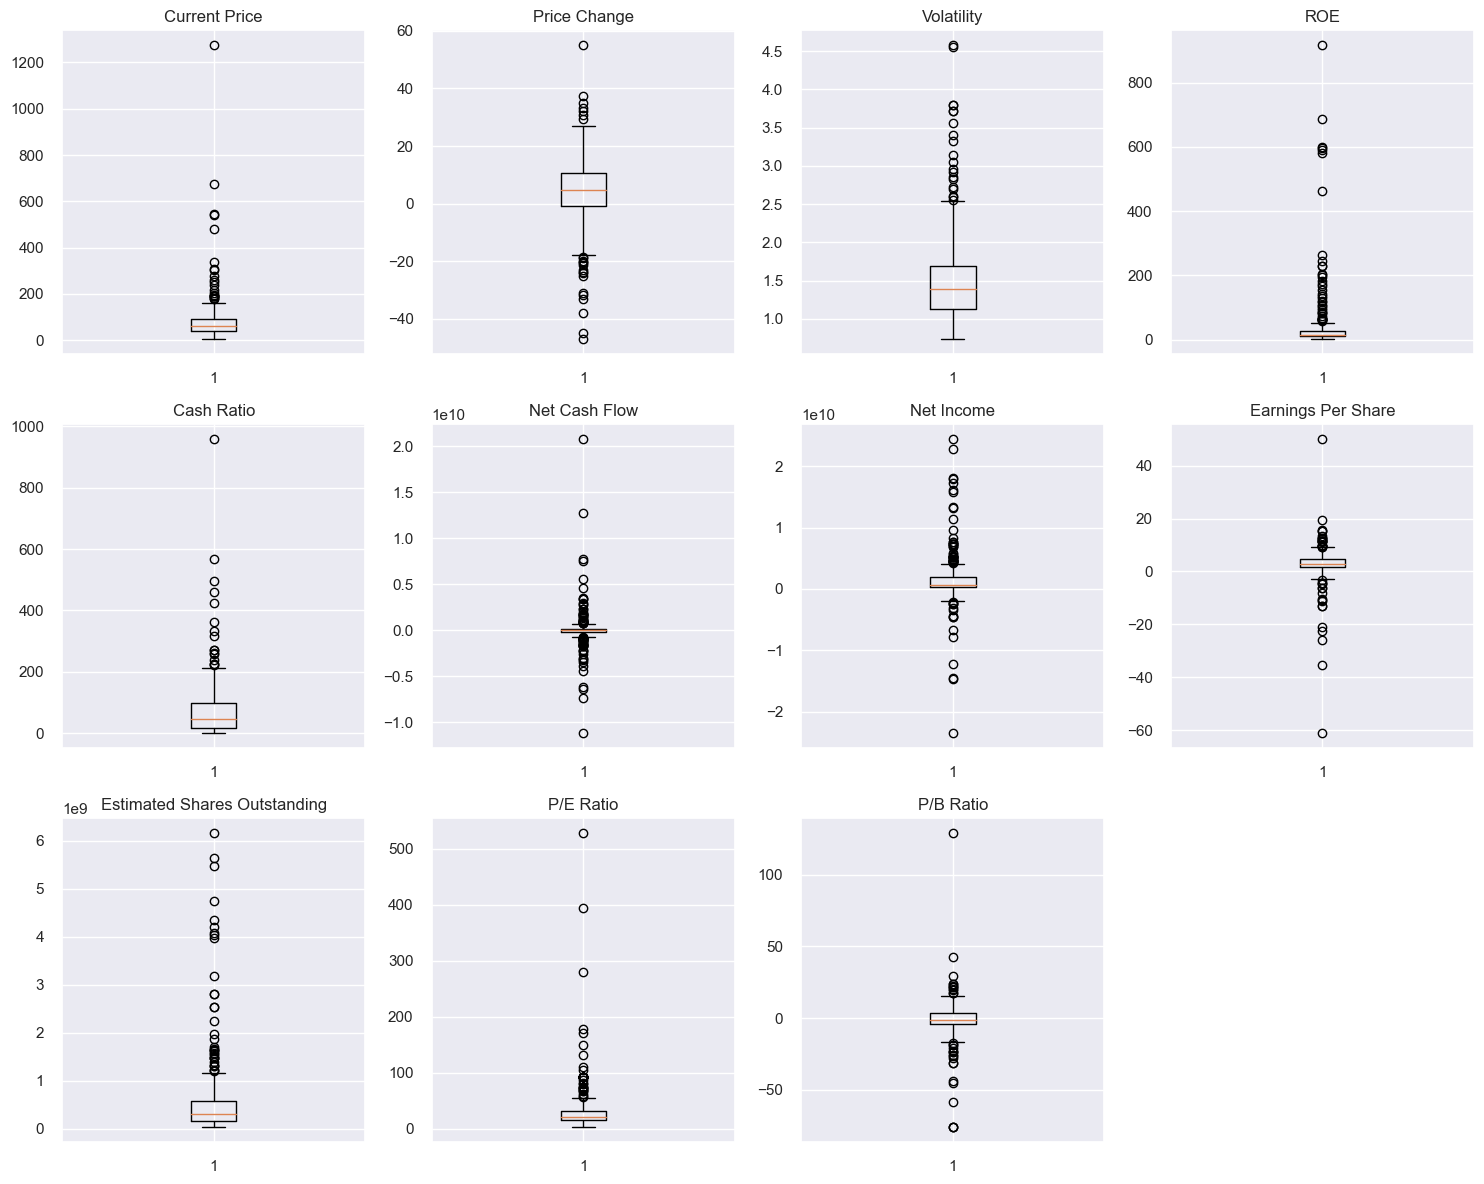

In [160]:
plt.figure(figsize=(15, 12))

numeric_columns2 = df.select_dtypes(include=np.number).columns.tolist()

for i, variable in enumerate(numeric_columns2):
    plt.subplot(3, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

- There are some outliers in the data.
- We will not treat them as they are proper values.

### Scaling

- Let's scale the data before we proceed with clustering.

In [161]:
# scaling the data before clustering
scaler = StandardScaler()
subset = df.iloc[:, 4:].copy()
subset_scaled = scaler.fit_transform(subset)

In [162]:
# creating a dataframe of the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

# K-means Clustering

In [163]:
k_means_df = subset_scaled_df.copy()

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.382318498894466
Number of Clusters: 3 	Average Distortion: 2.2692367155390745
Number of Clusters: 4 	Average Distortion: 2.175554082632614
Number of Clusters: 5 	Average Distortion: 2.136852169310594
Number of Clusters: 6 	Average Distortion: 2.0713095032364506
Number of Clusters: 7 	Average Distortion: 1.9775989987671811
Number of Clusters: 8 	Average Distortion: 1.9652603012304684
Number of Clusters: 9 	Average Distortion: 1.9311613101229932
Number of Clusters: 10 	Average Distortion: 1.8502089919483546
Number of Clusters: 11 	Average Distortion: 1.824801480357901
Number of Clusters: 12 	Average Distortion: 1.7525839358924042
Number of Clusters: 13 	Average Distortion: 1.722563828836958
Number of Clusters: 14 	Average Distortion: 1.6973594266503265


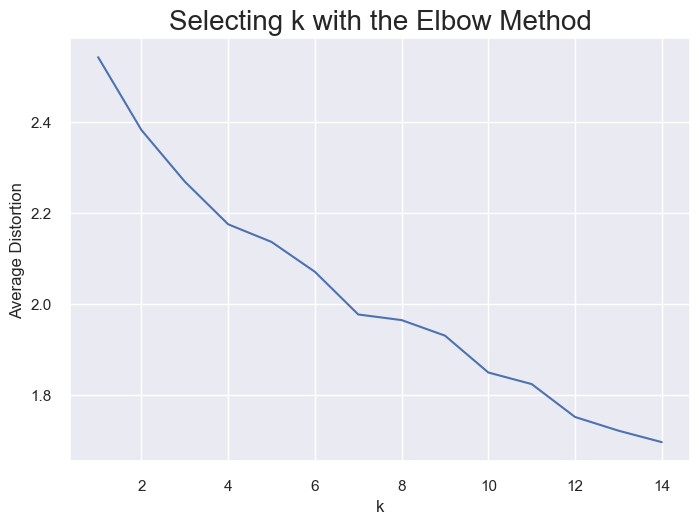

In [164]:
clusters = range(1, 15)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled_df)
    prediction = model.predict(k_means_df)
    distortion = (
        sum(np.min(cdist(k_means_df, model.cluster_centers_, "euclidean"), axis=1))
        / k_means_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.show()

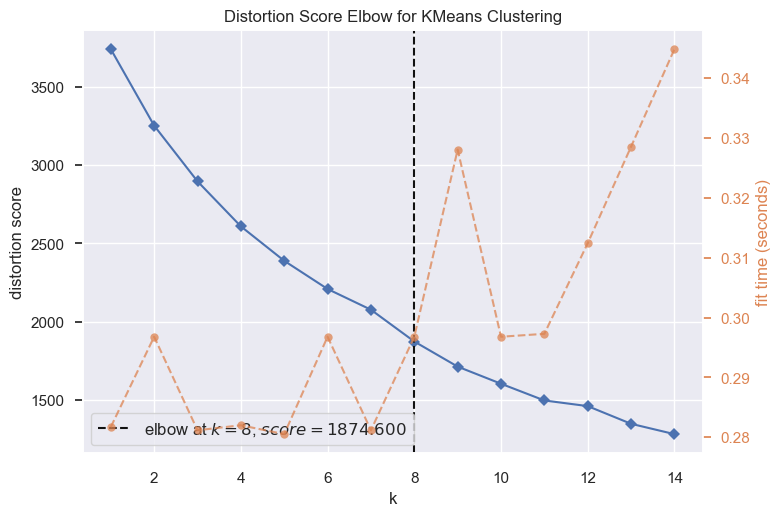

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [165]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(1, 15), timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

**Let's check the silhouette scores.**

For n_clusters = 2, the silhouette score is 0.43969639509980457)
For n_clusters = 3, the silhouette score is 0.4644405674779404)
For n_clusters = 4, the silhouette score is 0.45434371948348606)
For n_clusters = 5, the silhouette score is 0.43169988466492354)
For n_clusters = 6, the silhouette score is 0.36698524210914063)
For n_clusters = 7, the silhouette score is 0.10587349598463779)
For n_clusters = 8, the silhouette score is 0.40021596082234684)
For n_clusters = 9, the silhouette score is 0.4051539505522535)
For n_clusters = 10, the silhouette score is 0.1147132918355368)
For n_clusters = 11, the silhouette score is 0.16268826704862685)
For n_clusters = 12, the silhouette score is 0.12883008320005324)
For n_clusters = 13, the silhouette score is 0.1744804713048242)
For n_clusters = 14, the silhouette score is 0.17597674098501367)


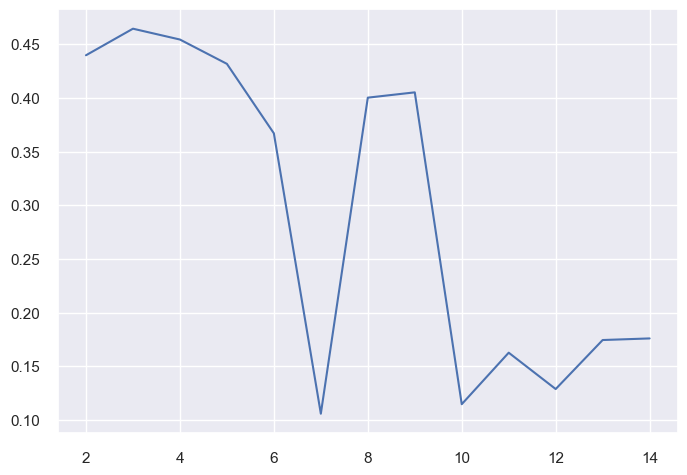

In [166]:
sil_score = []
cluster_list = range(2, 15)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((subset_scaled_df))
    score = silhouette_score(k_means_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

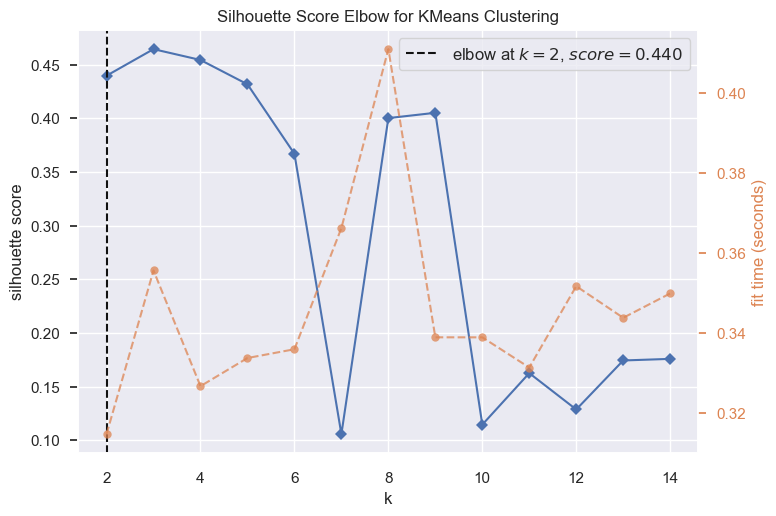

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [167]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

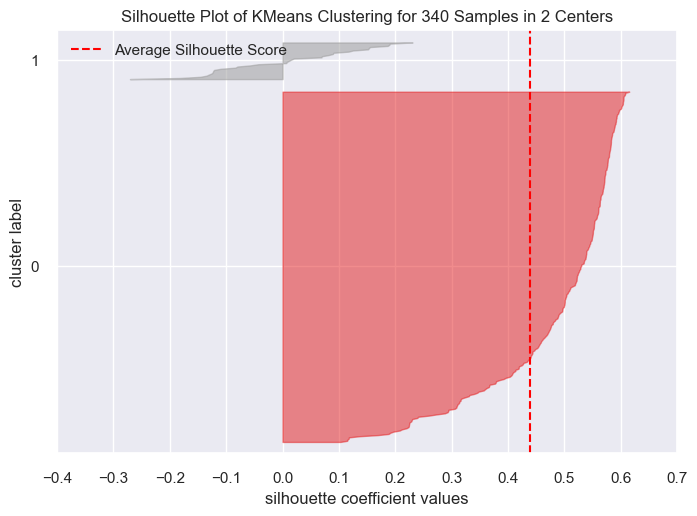

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 340 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [168]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

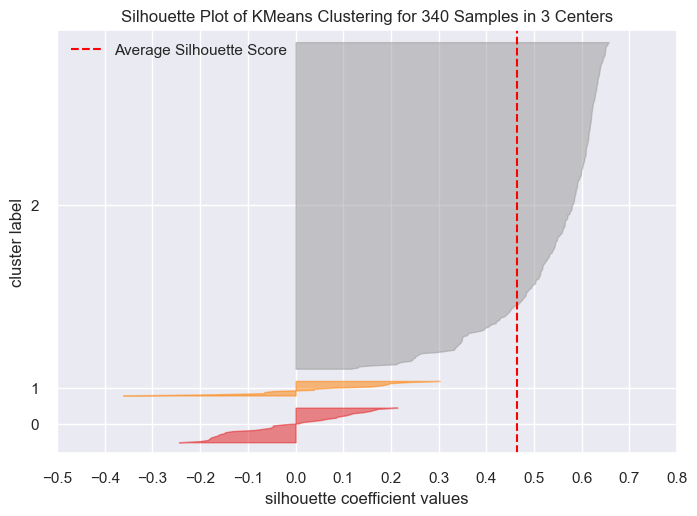

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 340 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [169]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

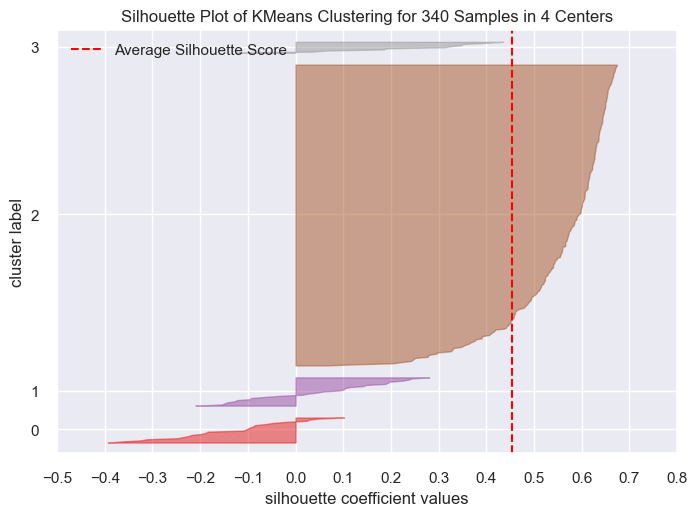

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 340 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [170]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

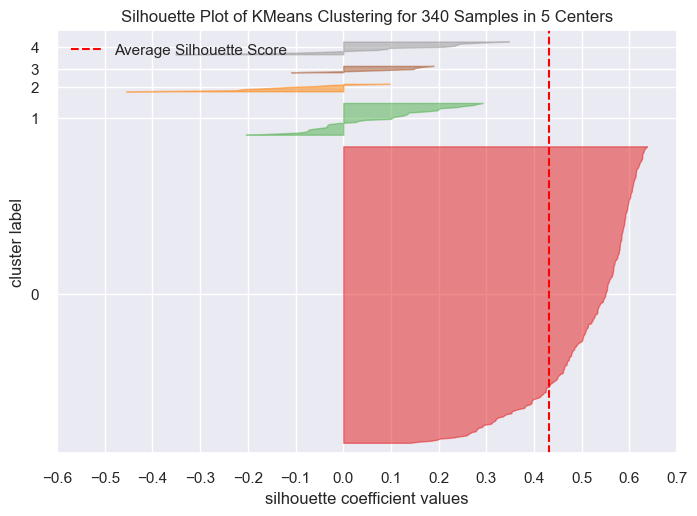

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 340 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [171]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

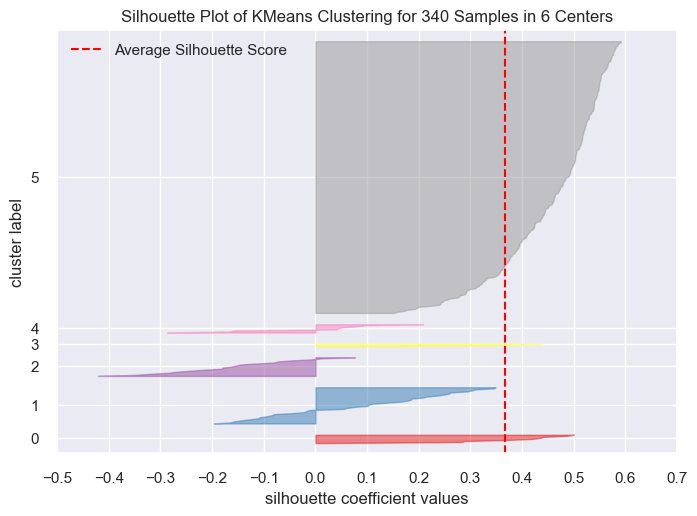

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 340 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [172]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

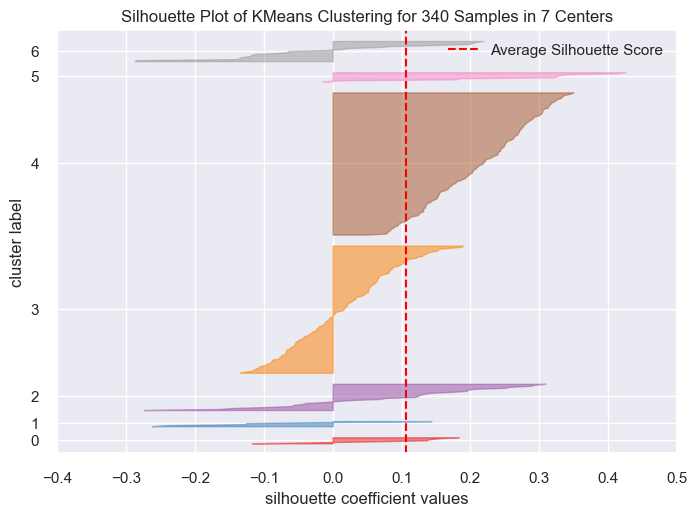

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 340 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [173]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(k_means_df)
visualizer.show()

**Observations**

- For 4 clusters, there is a nick in the elbow plot and the silhouette score is high too.
- So, we will move ahead with k=4.

In [174]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(k_means_df)

KMeans(n_clusters=4, random_state=1)

In [175]:
# creating a copy of the original data
df1 = df.copy()

# adding kmeans cluster labels to the original and scaled dataframes
k_means_df["KM_segments"] = kmeans.labels_
df1["KM_segments"] = kmeans.labels_

### Cluster Profiles

In [176]:
##km_cluster_profile = df1.groupby("KM_segments").mean()

In [177]:
df1[:5]

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,KM_segments
0,AAL,American Airlines Group,Industrials,Airlines,42.349998,9.999995,1.687151,135,51,-604000000,7610000000,11.39,6.681299e+08,3.718174,-8.784219,2
1,ABBV,AbbVie,Health Care,Pharmaceuticals,59.240002,8.339433,2.197887,130,77,51000000,5144000000,3.15,1.633016e+09,18.806350,-8.750068,2
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,44.910000,11.301121,1.273646,21,67,938000000,4423000000,2.94,1.504422e+09,15.275510,-0.394171,2
3,ADBE,Adobe Systems Inc,Information Technology,Application Software,93.940002,13.977195,1.357679,9,180,-240840000,629551000,1.26,4.996437e+08,74.555557,4.199651,2
4,ADI,"Analog Devices, Inc.",Information Technology,Semiconductors,55.320000,-1.827858,1.701169,14,272,315120000,696878000,0.31,2.247994e+09,178.451613,1.059810,0


In [178]:
km_cluster_profile = df1.groupby("KM_segments").size()
km_cluster_profile

KM_segments
0     24
1     27
2    278
3     11
dtype: int64

In [180]:
#km_cluster_profile["count_in_each_segment"] = (
    #df1.groupby("KM_segments")["Security"].count().values

#km_cluster_profile["count_in_each_segment"]

In [181]:
#km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

In [182]:
# Convert to a dataframe
km_cluster_profile_df = pd.DataFrame({'n': km_cluster_profile})
km_cluster_profile_df

# Highlight the maximum value
styled_data = km_cluster_profile_df.style.highlight_max(color="lightgreen", axis=0)
styled_data

,n
KM_segments,
0,24
1,27
2,278
3,11


In [183]:
km_cluster_profile_df = pd.DataFrame({'n': km_cluster_profile})
km_cluster_profile_df

,n
KM_segments,
0,24
1,27
2,278
3,11


In [184]:
styled_data = km_cluster_profile_df.style.highlight_max(color="lightgreen", axis=0)
styled_data

,n
KM_segments,
0,24
1,27
2,278
3,11


In [185]:
# let's see the names of the companies in each cluster
for cl in df1["KM_segments"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(df1[df1["KM_segments"] == cl]["Security"].unique())
    print()

In cluster 2, the following companies are present:
['American Airlines Group' 'AbbVie' 'Abbott Laboratories'
 'Adobe Systems Inc' 'Archer-Daniels-Midland Co' 'Ameren Corp'
 'American Electric Power' 'AFLAC Inc'
 'American International Group, Inc.' 'Apartment Investment & Mgmt'
 'Assurant Inc' 'Arthur J. Gallagher & Co.' 'Akamai Technologies Inc'
 'Albemarle Corp' 'Alaska Air Group Inc' 'Allstate Corp' 'Allegion'
 'Applied Materials Inc' 'AMETEK Inc' 'Affiliated Managers Group Inc'
 'Ameriprise Financial' 'American Tower Corp A' 'AutoNation Inc'
 'Anthem Inc.' 'Aon plc' 'Amphenol Corp' 'Arconic Inc'
 'Activision Blizzard' 'AvalonBay Communities, Inc.' 'Broadcom'
 'American Water Works Company Inc' 'American Express Co' 'Boeing Company'
 'Bank of America Corp' 'Baxter International Inc.' 'BB&T Corporation'
 'Bard (C.R.) Inc.' 'The Bank of New York Mellon Corp.' 'Ball Corp'
 'Bristol-Myers Squibb' 'Boston Scientific' 'BorgWarner'
 'Boston Properties' 'Caterpillar Inc.' 'Chubb Limited' 'C

In [186]:
df1.groupby(["KM_segments", "GICS Sector"])['Security'].count()

KM_segments  GICS Sector                
0            Consumer Discretionary          6
             Consumer Staples                1
             Energy                          1
             Health Care                     9
             Information Technology          5
             Real Estate                     1
             Telecommunications Services     1
1            Energy                         22
             Industrials                     1
             Information Technology          3
             Materials                       1
2            Consumer Discretionary         33
             Consumer Staples               17
             Energy                          6
             Financials                     46
             Health Care                    29
             Industrials                    52
             Information Technology         24
             Materials                      19
             Real Estate                    26
             Teleco

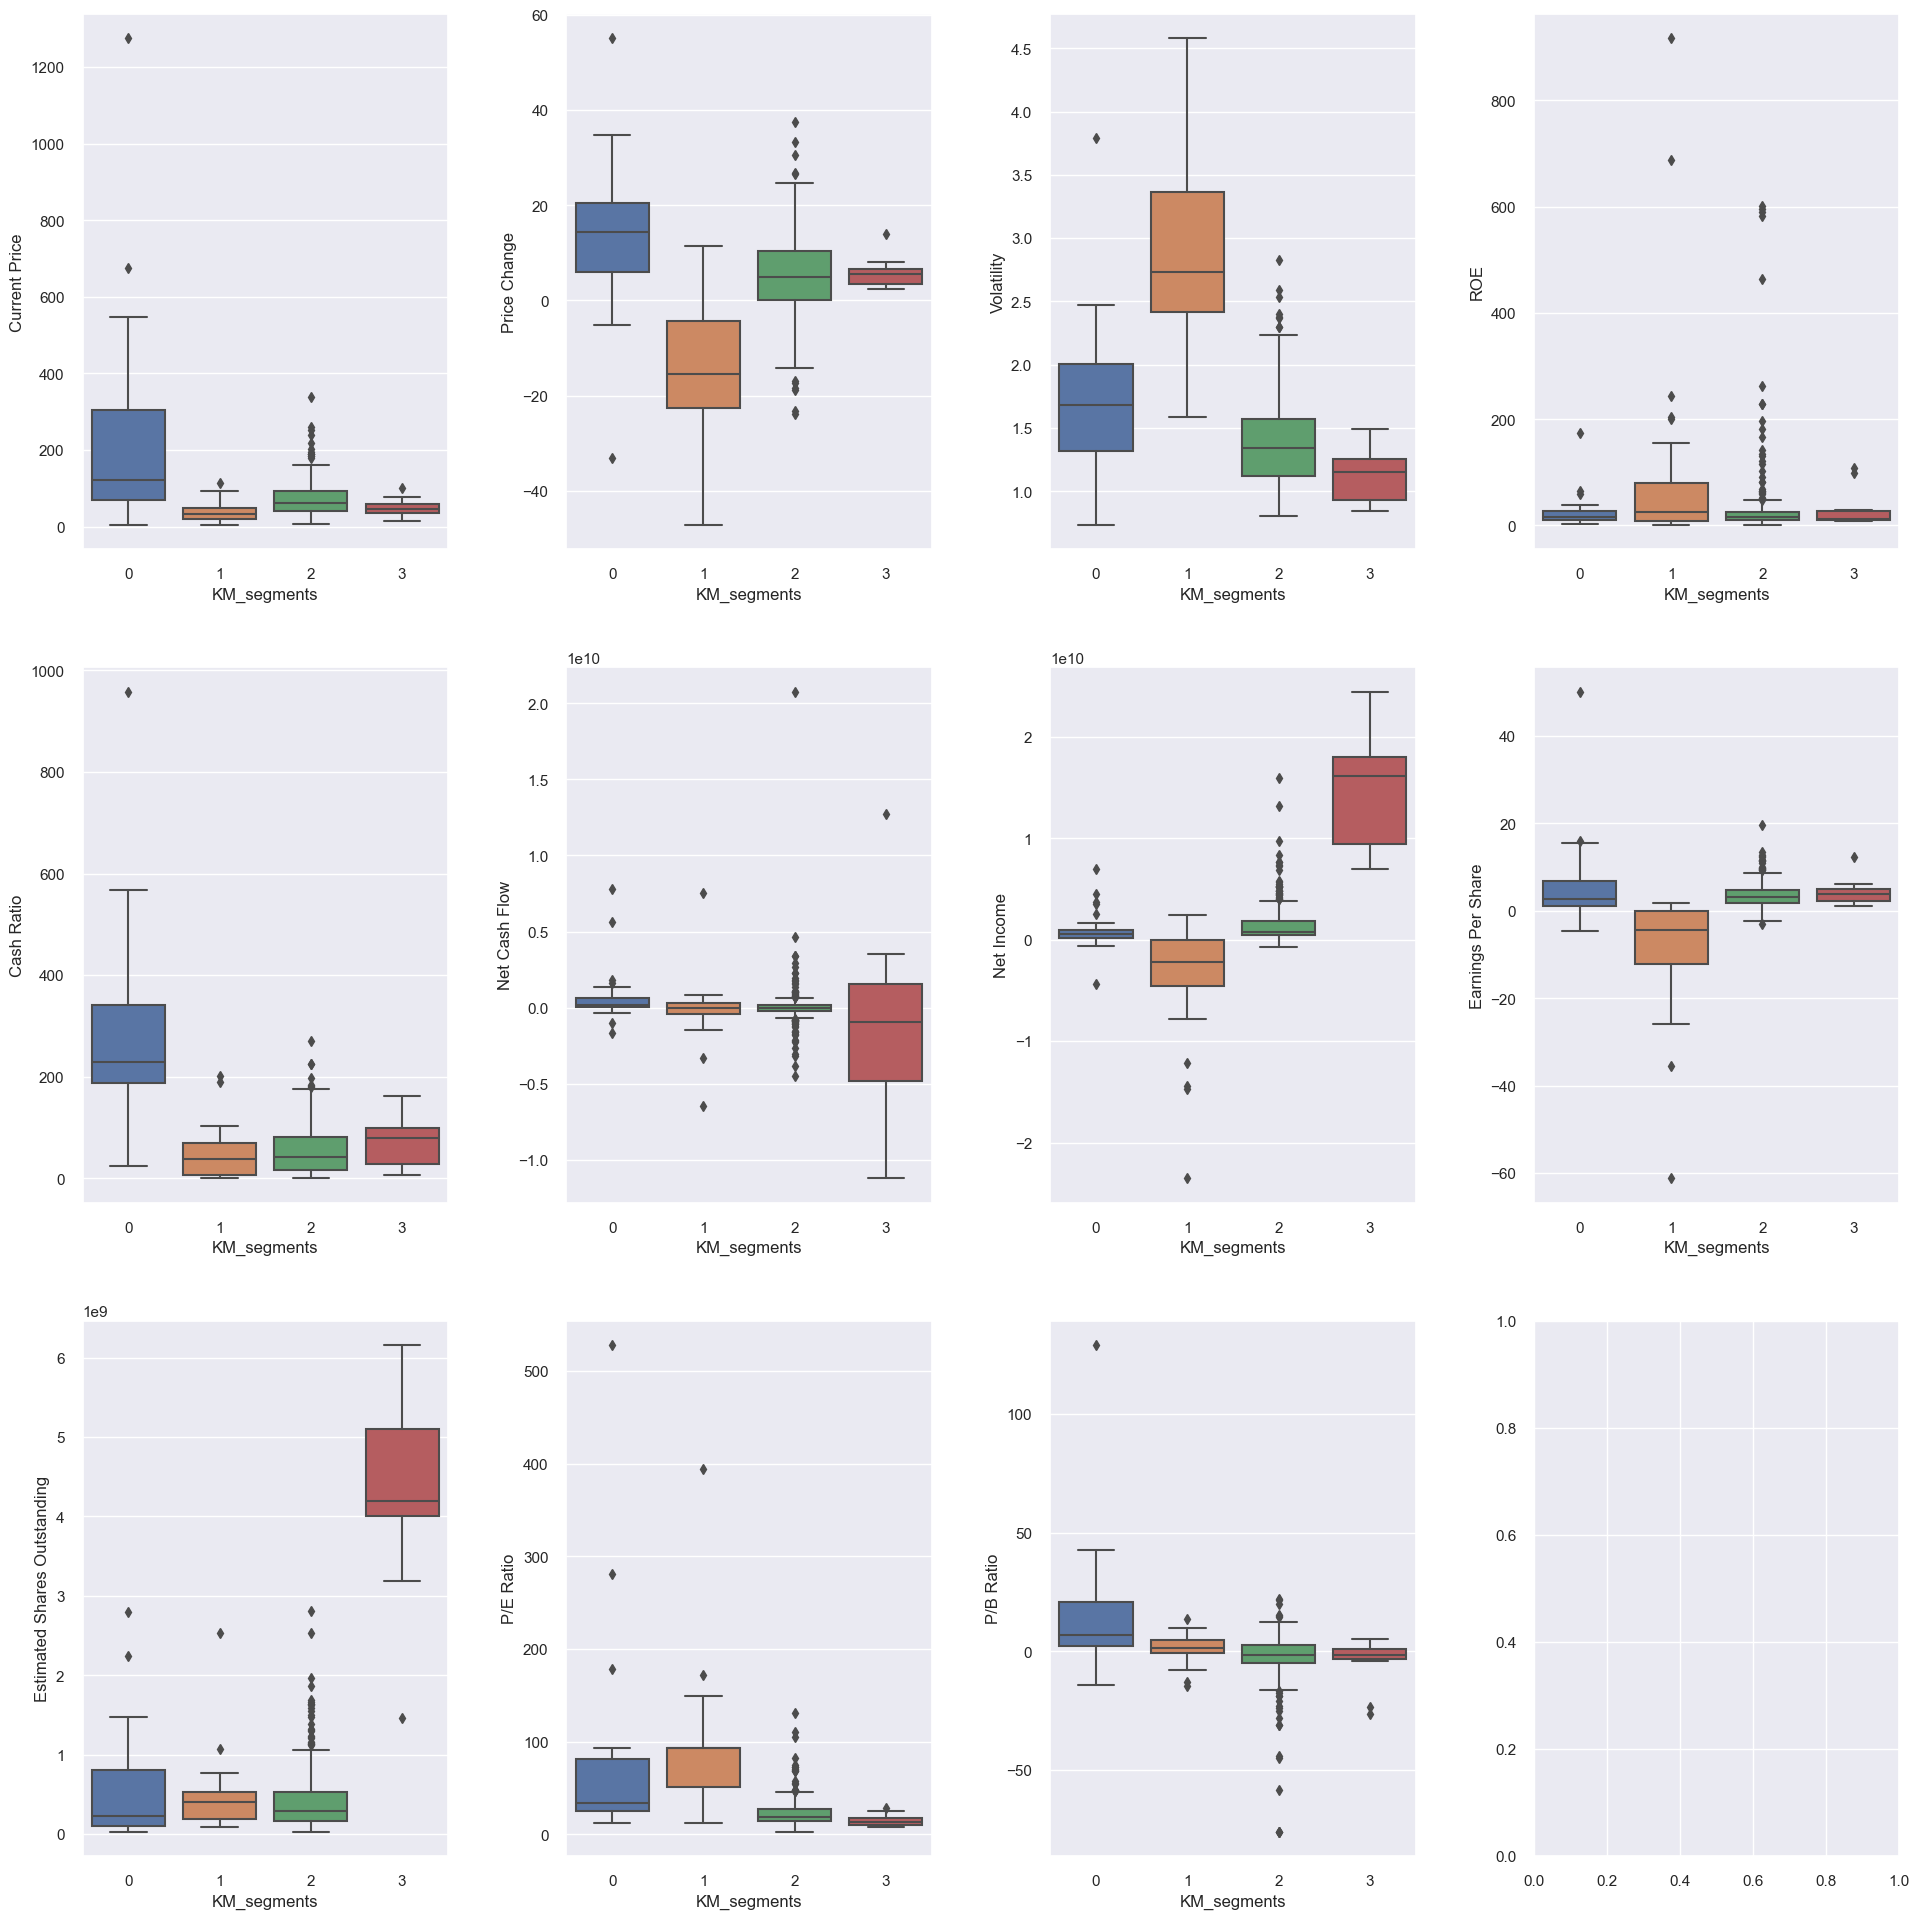

In [187]:
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
counter = 0

for ii in range(3):
    for jj in range(4):
        if counter < 11:
            sns.boxplot(
                ax=axes[ii][jj],
                data=df1,
                y=df1.columns[4+counter],
                x="KM_segments",
            )
            counter = counter + 1

fig.tight_layout(pad=3.0)

# Insights

- **Cluster 0**
    - There are 277 companies in this cluster.
    - The stocks of the companies in this cluster have a moderate price, low volatility, and have witnessed a 5% price rise on average.
    - These companies have a low cash ratio and low positive net income.
    - These companies have a low P/E ratio and a low number of outstanding shares.


- **Cluster 1**
    - There are 11 companies in this cluster.
    - The stocks of the companies in this cluster have a low price, low volatility, and have witnessed a 6% price rise on average.
    - These companies have a low cash ratio and high positive net income.
    - These companies have a low P/E ratio and a high number of outstanding shares.


- **Cluster 2**
    - There are 27 companies in this cluster.
    - The stocks of the companies in this cluster have a low price, high volatility, and have witnessed an 15% price drop on average.
    - These companies have a low cash ratio and negative net income.
    - These companies have a high P/E ratio and a low number of outstanding shares.


- **Cluster 3**
    - There are 25 companies in this cluster.
    - The stocks of the companies in this cluster have a high price, moderate volatility, and have witnessed a 13.5% price rise on average.
    - These companies have a high cash ratio and low positive net income.
    - These companies have a moderate P/E ratio and low to moderate number of outstanding shares.

# Hierarchical Clustering

In [213]:
hc_df = subset_scaled_df.copy()
hc_df[:2]

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,-0.393341,0.493950,0.272749,0.989601,-0.210698,-0.339355,1.554415,1.309399,0.107863,-0.652487,-0.506653
1,-0.220837,0.355439,1.137045,0.937737,0.077269,-0.002335,0.927628,0.056755,1.250274,-0.311769,-0.504205


In [214]:
hc_clustering= linkage(hc_df, method='ward')

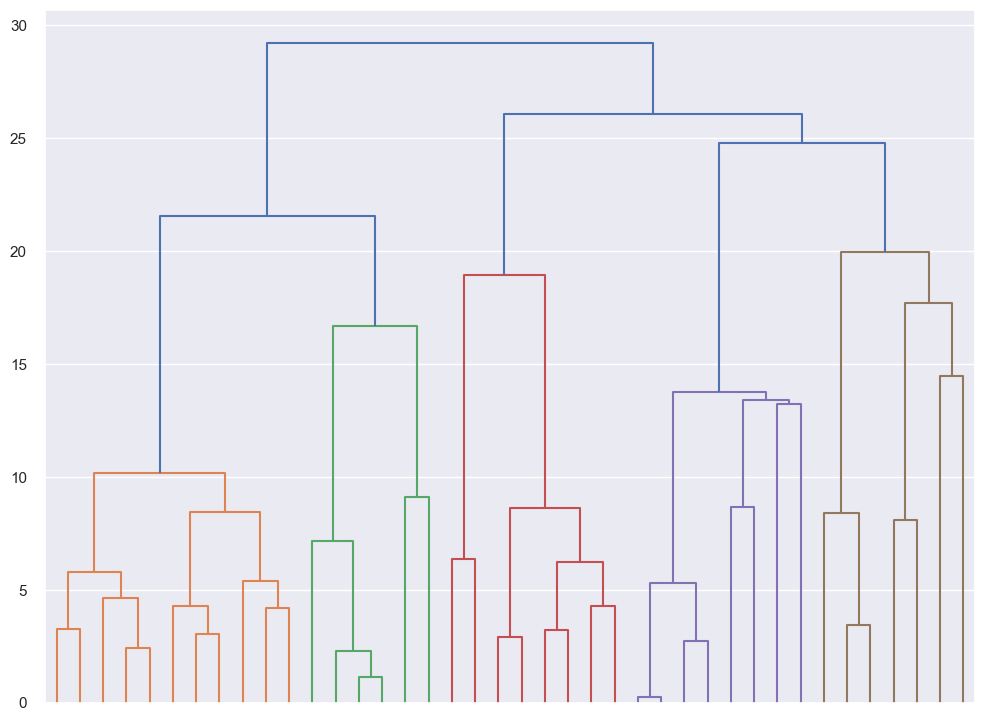

In [215]:
plt.figure(figsize=(12, 9))
dendrogram(hc_clustering,
          truncate_mode='level',
          p=5,
          show_leaf_counts=False,
          no_labels=True)
plt.show()

In [191]:
hc_df = subset_scaled_df.copy()

In [192]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hc_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(hc_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm
            
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print('*'*100)
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Cophenetic correlation for Euclidean distance and single linkage is 0.9232271494002922.
Cophenetic correlation for Euclidean distance and complete linkage is 0.7873280186580672.
Cophenetic correlation for Euclidean distance and average linkage is 0.9422540609560814.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8693784298129404.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9062538164750717.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.598891419111242.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9338265528030499.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9127355892367.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9259195530524591.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.7925307202850002.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9247324030159737.
Cophenetic correl

**Let's explore different linkage methods with Euclidean distance only.**

In [193]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(hc_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(hc_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm
        
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print('*'*100)
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Cophenetic correlation for single linkage is 0.9232271494002922.
Cophenetic correlation for complete linkage is 0.7873280186580672.
Cophenetic correlation for average linkage is 0.9422540609560814.
Cophenetic correlation for centroid linkage is 0.9314012446828154.
Cophenetic correlation for ward linkage is 0.7101180299865353.
Cophenetic correlation for weighted linkage is 0.8693784298129404.
****************************************************************************************************
Highest cophenetic correlation is 0.9422540609560814, which is obtained with average linkage.


**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.**


**Let's view the dendrograms for the different linkage methods.**

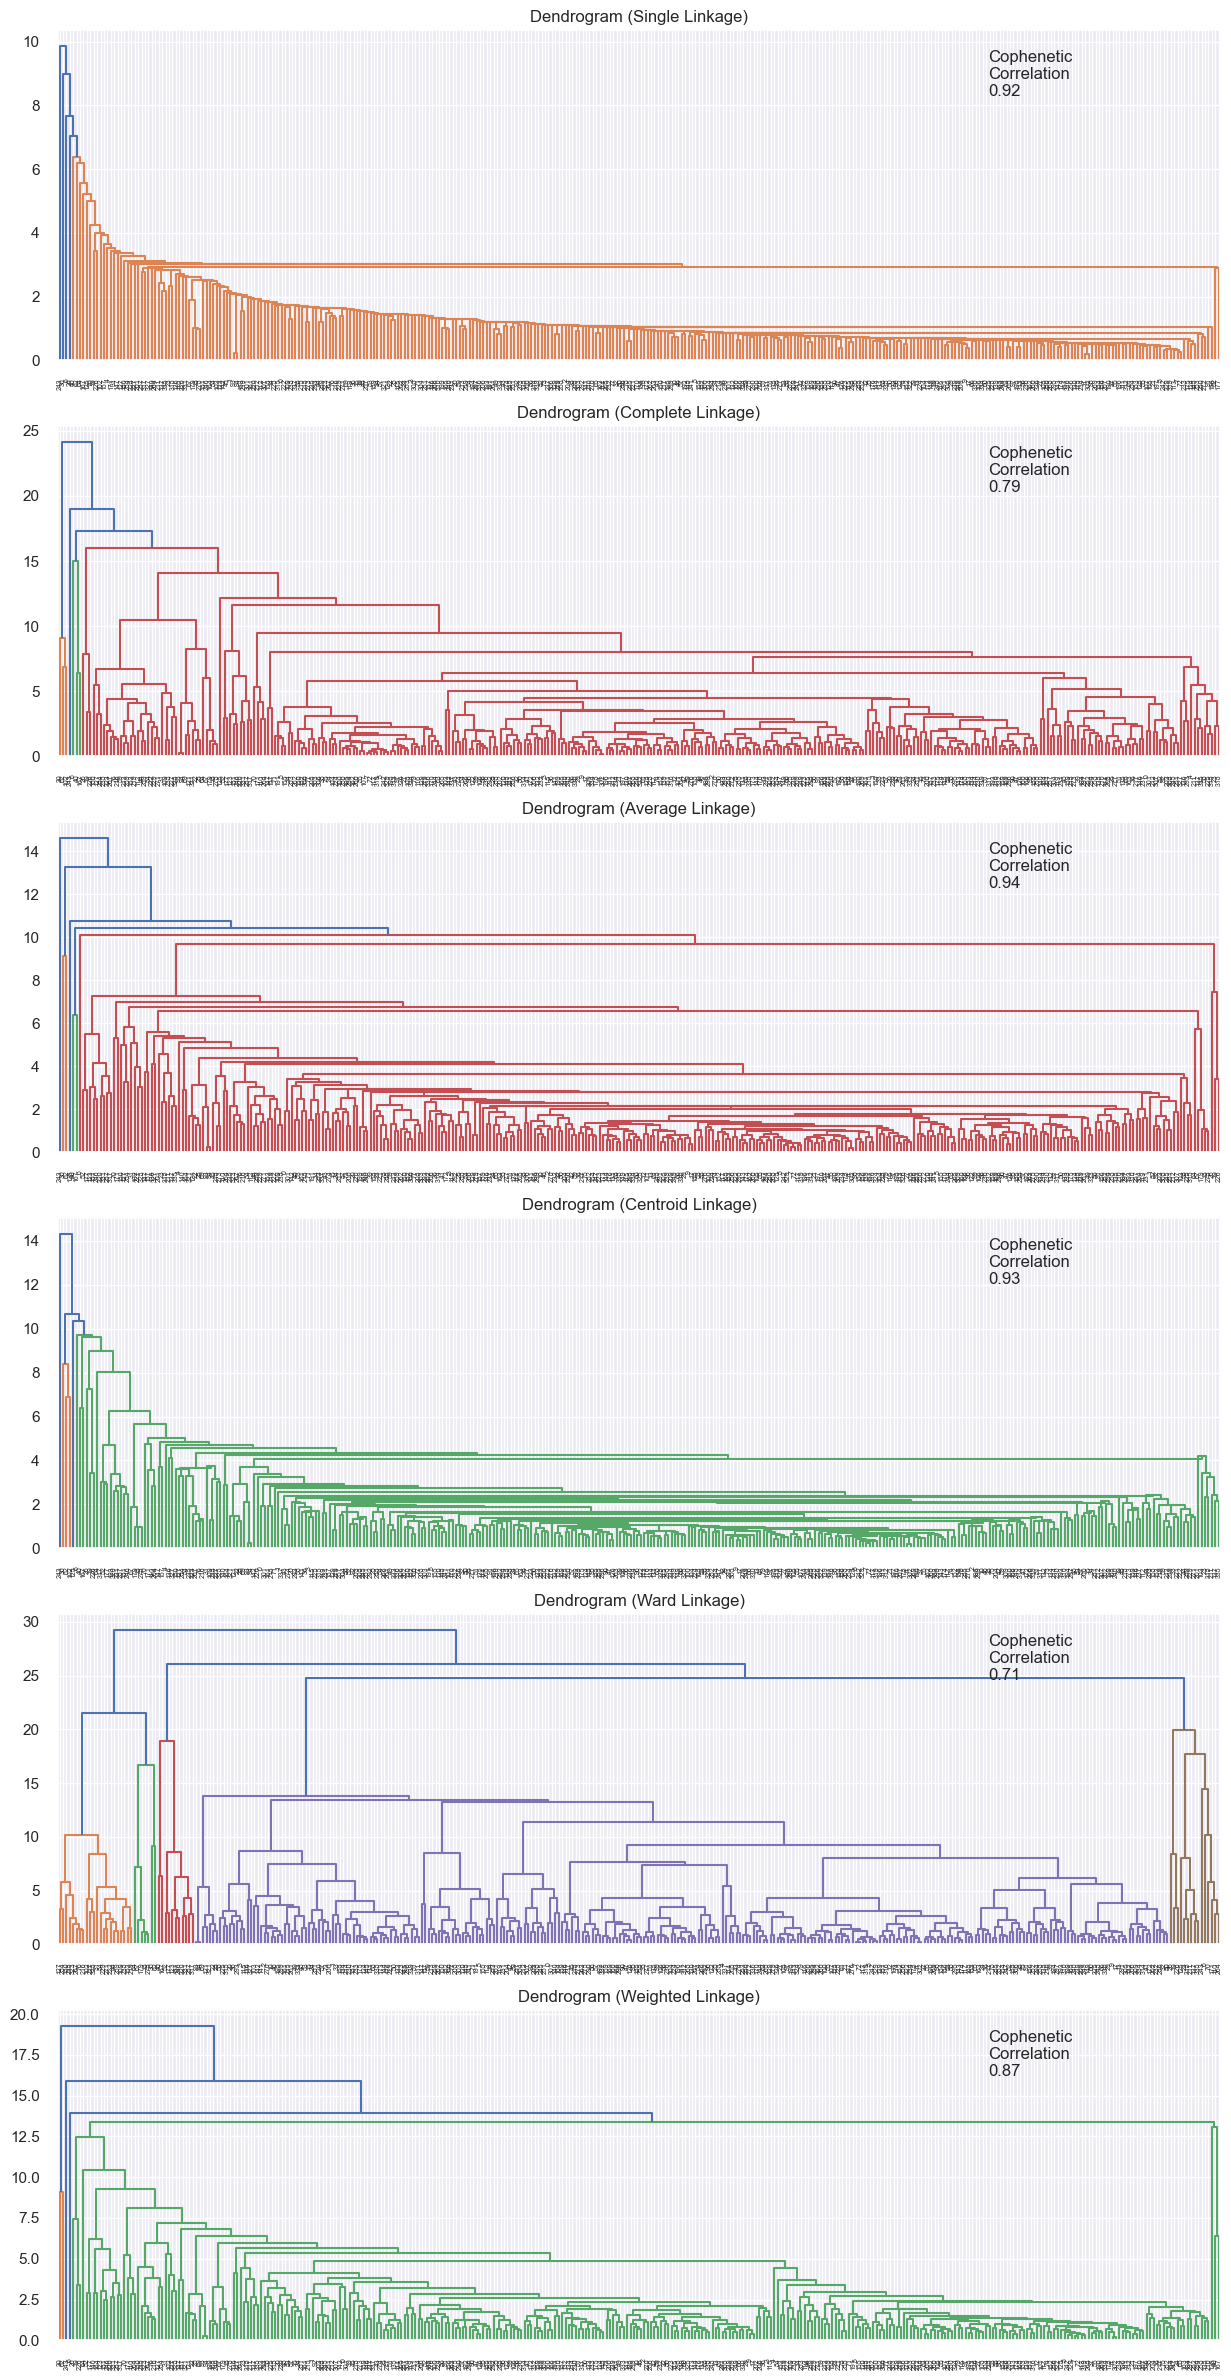

In [194]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hc_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hc_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
    
    compare.append([method, coph_corr])

In [195]:
# create and print a dataframe to compare cophenetic correlations for different linkage methods
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

,Linkage,Cophenetic Coefficient
4,ward,0.710118
1,complete,0.787328
5,weighted,0.869378
0,single,0.923227
3,centroid,0.931401
2,average,0.942254


**Let's move ahead with 3 clusters, Euclidean distance, and average linkage.**

In [196]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(hc_df)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=3)

In [197]:
# creating a copy of the original data
df2 = df.copy()

# adding hierarchical cluster labels to the original and scaled dataframes
hc_df["HC_segments"] = HCmodel.labels_
df2["HC_segments"] = HCmodel.labels_

### Cluster Profiling

In [198]:
hc_cluster_profile = df2.groupby("HC_segments").size()
hc_cluster_profile

HC_segments
0    337
1      1
2      2
dtype: int64

In [199]:
#hc_cluster_profile["count_in_each_segment"] = (
    #df2.groupby("HC_segments")["Security"].count().value()

In [200]:
# Convert to a dataframe
#km_cluster_profile_df = pd.DataFrame({'n': km_cluster_profile})

# Highlight the maximum value
#styled_data2 = km_cluster_profile_df.style.highlight_max(color="lightgreen", axis=0)

In [201]:
# Convert to a dataframe
hc_cluster_profile_df = pd.DataFrame({'n': hc_cluster_profile})
hc_cluster_profile_df

,n
HC_segments,
0,337
1,1
2,2


In [202]:
# Highlight the maximum value
styled_data2 = hc_cluster_profile_df.style.highlight_max(color="lightgreen", axis=0)
styled_data2

,n
HC_segments,
0,337
1,1
2,2


In [203]:
#hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

In [204]:
# let's see the names of the companies in each cluster
for cl in df2["HC_segments"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(df2[df2["HC_segments"] == cl]["Security"].unique())
    print()

In cluster 0, the following companies are present:
['American Airlines Group' 'AbbVie' 'Abbott Laboratories'
 'Adobe Systems Inc' 'Analog Devices, Inc.' 'Archer-Daniels-Midland Co'
 'Alliance Data Systems' 'Ameren Corp' 'American Electric Power'
 'AFLAC Inc' 'American International Group, Inc.'
 'Apartment Investment & Mgmt' 'Assurant Inc' 'Arthur J. Gallagher & Co.'
 'Akamai Technologies Inc' 'Albemarle Corp' 'Alaska Air Group Inc'
 'Allstate Corp' 'Allegion' 'Alexion Pharmaceuticals'
 'Applied Materials Inc' 'AMETEK Inc' 'Affiliated Managers Group Inc'
 'Amgen Inc' 'Ameriprise Financial' 'American Tower Corp A'
 'Amazon.com Inc' 'AutoNation Inc' 'Anthem Inc.' 'Aon plc'
 'Anadarko Petroleum Corp' 'Amphenol Corp' 'Arconic Inc'
 'Activision Blizzard' 'AvalonBay Communities, Inc.' 'Broadcom'
 'American Water Works Company Inc' 'American Express Co' 'Boeing Company'
 'Bank of America Corp' 'Baxter International Inc.' 'BB&T Corporation'
 'Bard (C.R.) Inc.' 'Baker Hughes Inc' 'BIOGEN IDEC I

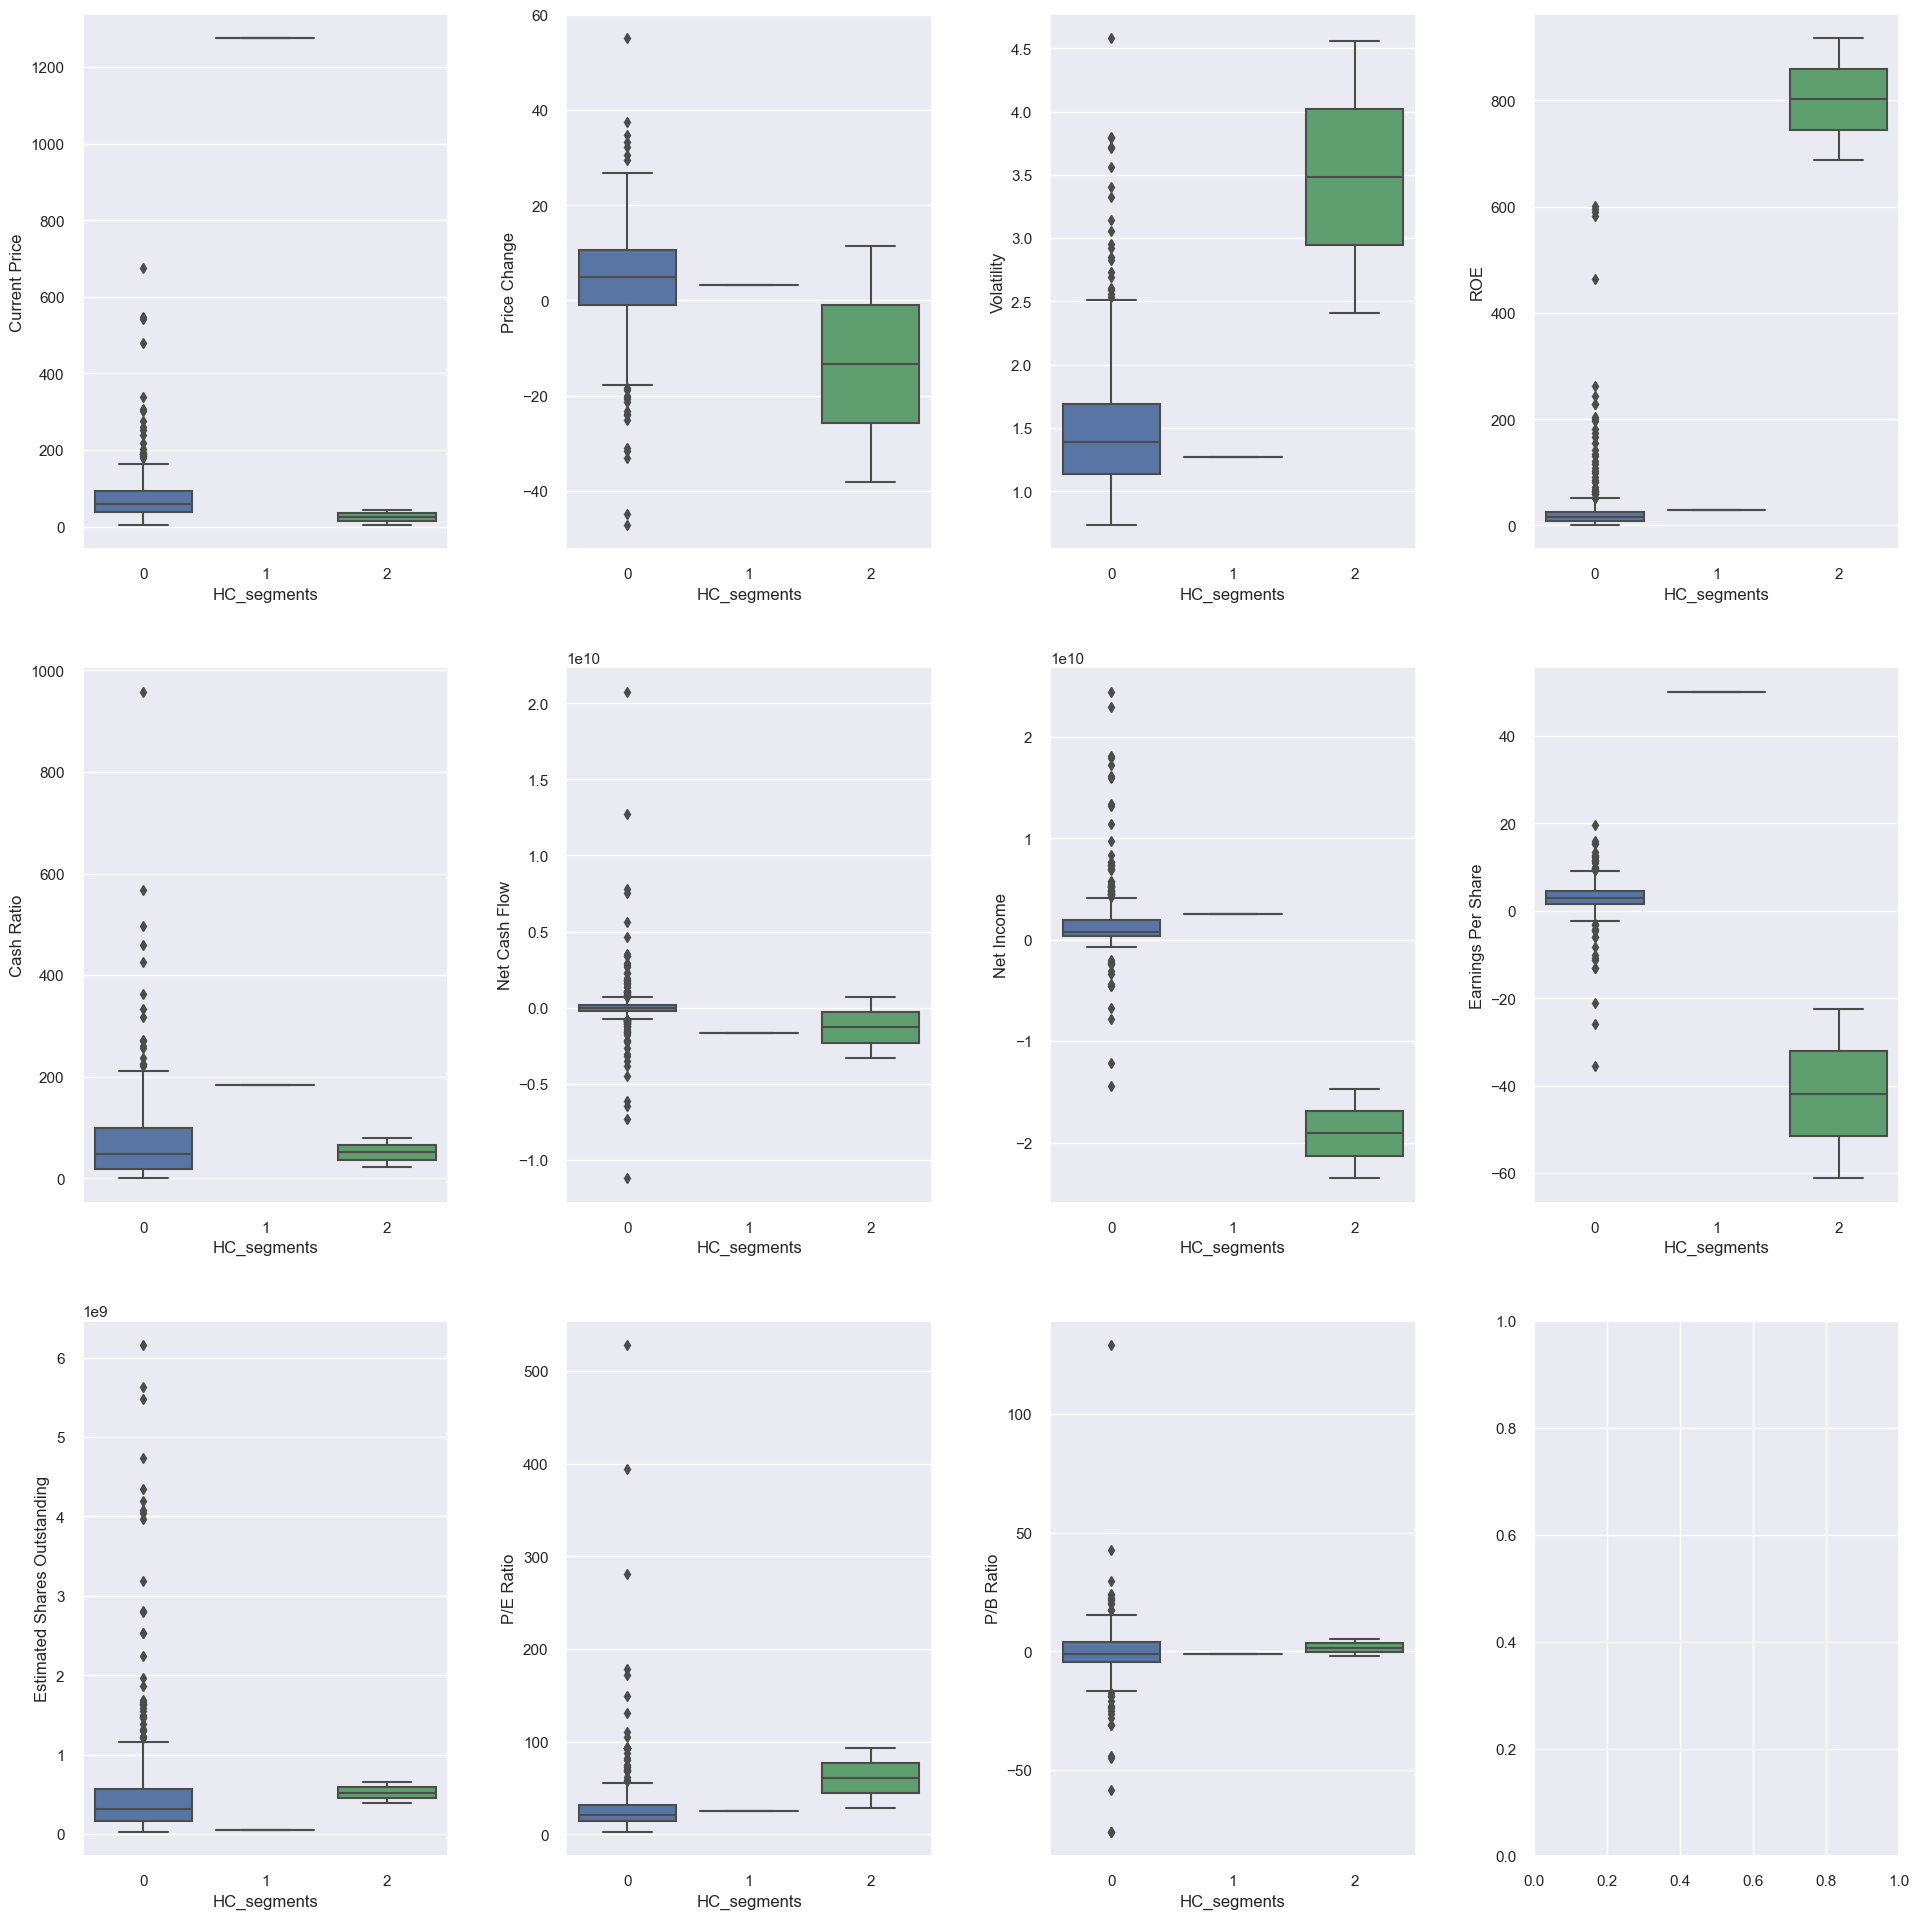

In [205]:
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
counter = 0

for ii in range(3):
    for jj in range(4):
        if counter < 11:
            sns.boxplot(
                ax=axes[ii][jj],
                data=df2,
                y=df2.columns[4+counter],
                x="HC_segments",
            )
            counter = counter + 1

fig.tight_layout(pad=3.0)

### Insights

- **Cluster 0**
    - There are 29 companies in this cluster.
    - The stocks of the companies in this cluster have a low price, high volatility, and have witnessed an 11% price drop on average.
    - These companies have a low cash ratio and negative net income.
    - These companies have a high P/E ratio and a low number of outstanding shares.


- **Cluster 1**
    - There are 15 companies in this cluster.
    - The stocks of the companies in this cluster have a high price, moderate volatility, and have witnessed a 10.5% price rise on average.
    - These companies have a high cash ratio and low positive net income.
    - These companies have a high P/E ratio and a low number of outstanding shares.


- **Cluster 2**
    - There are 11 companies in this cluster.
    - The stocks of the companies in this cluster have a low price, low volatility, and have witnessed a 6% rise drop on average.
    - These companies have a moderate cash ratio and high positive net income.
    - These companies have a low P/E ratio and a high number of outstanding shares.


- **Cluster 3**
    - There are 285 companies in this cluster.
    - The stocks of the companies in this cluster have a moderate price, low volatility, and have witnessed a 5% price rise on average.
    - These companies have a moderate cash ratio and moderate positive net income.
    - These companies have a moderate P/E ratio and a low number of outstanding shares.

# K-means vs Hierarchical Clustering

- Both K-means and Hierarchical clustering yield two similar clusters and two slightly dissimilar clusters.
- Few companies were swapped between the clusters obtained using both techniques.
- The sklearn implementations of both the techniques take nearly the same amount of time to execute. However, dendrograms in Hierarchical clustering take a more time to render.

**We will move ahead with the clusters obtained using Hierarchical clustering.**

In [206]:
# Highlight the maximum value
styled_data2 = hc_cluster_profile_df.style.highlight_max(color="lightgreen", axis=0)
styled_data2

,n
HC_segments,
0,337
1,1
2,2


In [207]:
df2.groupby(["HC_segments", "GICS Sector"])['Security'].count()

HC_segments  GICS Sector                
0            Consumer Discretionary         39
             Consumer Staples               19
             Energy                         28
             Financials                     49
             Health Care                    40
             Industrials                    53
             Information Technology         33
             Materials                      20
             Real Estate                    27
             Telecommunications Services     5
             Utilities                      24
1            Consumer Discretionary          1
2            Energy                          2
Name: Security, dtype: int64

## Actionable Insights and Recommendations

- **Cluster 0** companies are the ones who performed poorly in the previous quarter. Most of the companies in this cluster are from the Energy sector, which as a whole performed poorly in the previous quarter. Investors will have to be careful and dig deeper into the financial statements of these companies for a better analysis.


- **Cluster 1** companies have highly-priced stocks and have shown the most growth in the previous quarter. Large proportions of stocks in this cluster are from Healthcare and IT sectors. The high earnings per share also indicate that these stocks will justify their high price tag with good returns. The high P/E ratio indicates that these stocks are either overvalued or investors expect good growth potential from these companies.


- **Cluster 2** companies are the ones which have a low price and have had a great previous quarter. They are less riskier investments and are traded in large volumes. The low P/E ratio might also indicate that these stocks are undervalued, but we will have to dig deeper to conclude the same with confidence.


- **Cluster 3** company stocks are moderately priced and are less volatile. They had a good previous quarter and their stocks are traded in moderate volumes. The moderate earnings per share also indicate that these stocks will yield good returns.


- Trade&Ahead should look into more financial (fundamental and technical) indicators to make better predictions of stock price movements and assessment of company valuation.


- They should also conduct cluster analysis separately for each of the economic sectors as it will help them to provide better investment recommendations to their clients.

## Add-on: PCA for visualization

- Let's use PCA to reduce the data to two dimensions and visualize it to see how well-separated the clusters are.

In [208]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(subset_scaled_df)

# storing results in a dataframe
reduced_data_df_pca = pd.DataFrame(data = X_reduced_pca, columns = ['Component 1', 'Component 2'])

# checking the amount of variance explained
print(f'The first two principal components explain {np.round(100*pca.explained_variance_ratio_.sum(), 2)}% of the variance in the data.')

The first two principal components explain 37.13% of the variance in the data.


<Axes: xlabel='Component 1', ylabel='Component 2'>

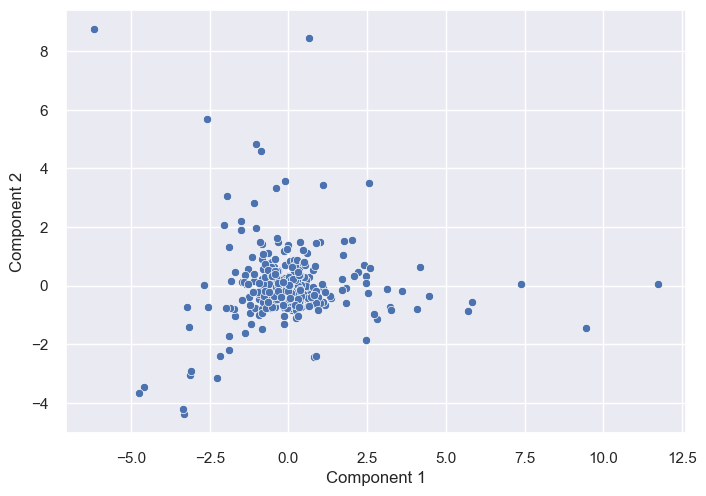

In [209]:
sns.scatterplot(data=reduced_data_df_pca, x='Component 1', y='Component 2')

<Axes: xlabel='Component 1', ylabel='Component 2'>

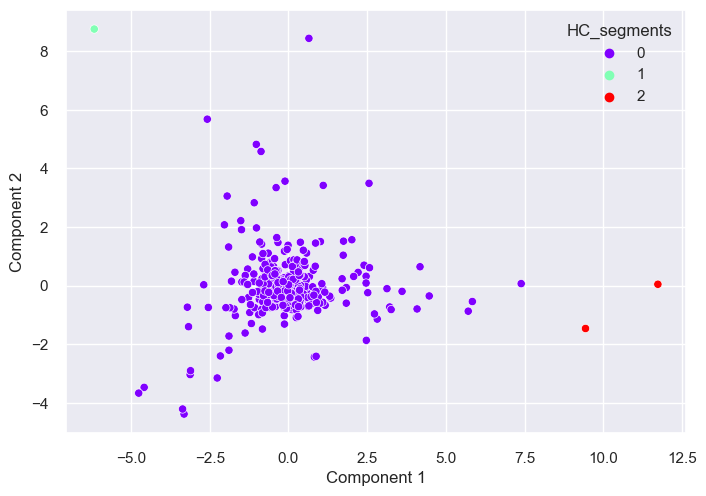

In [210]:
sns.scatterplot(data=reduced_data_df_pca, x='Component 1', y='Component 2', hue=df2["HC_segments"], palette='rainbow')

- The clusters are not very well separated.
- Cluster 3 points are concentrated in the middle of the plot and points from the rest of the clusters surround them in three different directions.